<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, pathloss step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

os.chdir(data_dir.name)

In [2]:
# Choose CRDS cache location
use_local_crds_cache = False
crds_cache_tempdir = False
crds_cache_notebook_dir = True
crds_cache_home = False
crds_cache_custom_dir = False
crds_cache_dir_name = ""

if use_local_crds_cache:
    if crds_cache_tempdir:
        os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_notebook_dir:
        try:
            os.environ['CRDS_PATH'] = os.path.join(orig_dir, "crds")
        except Exception as e:
            os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_home:
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif crds_cache_custom_dir:
        os.environ['CRDS_PATH'] = crds_cache_dir_name

In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst.extract_2d.extract_2d_step import Extract2dStep
    from jwst.srctype.srctype_step import SourceTypeStep
    from jwst.flatfield.flat_field_step import FlatFieldStep
    from jwst.pathloss.pathloss_step import PathLossStep
    from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [4]:
# Make sure that the version used is the right one

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.1.0
Using NPTT version:  1.1.6.dev0+g47147b2.d20210219


<a id="intro_ID"></a>
# Test Description

The NIRSpec team developed an implementation of the pathloss step and compared the output to the pipeline output for this step. We expected machine precision differences (about 10^-7) but due to rounding differences in interpolation methods we relaxed the difference threshold to 10^-6. 

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py. There is a corresponding script for Multi Object Spectroscopy (MOS) and for Integral Field Unit (IFU) data. Each mode has a script for point source (ps) and for uniform source (uni).


Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pathloss/description.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/pathloss


### Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information 


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and pathloss validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the pathloss step, use the command:

$ strun jwst.pathloss.PathLossStep jwtest_previous_step_output.fits


These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.pathloss import PathLossStep
 
$\gt$ PathLossStep.call(jwtest_previous_step_output.fits)


PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests. To run PTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing was only FS and MOS, since extract_2d is skipped for IFU. Data sets are:
- FS_PRISM_CLEAR
- FS_FULLFRAME_G395H_F290LP
- FS_ALLSLITS_G140H_F100LP 
- MOS_G140M_LINE1 
- MOS_PRISM_CLEAR
- IFU_G395H_F290LP 
- IFU_PRISM_CLEAR


[Top of Page](#title_ID)

In [5]:
testing_data = {
                
                'mos_prism_clear':{
                                  'uncal_file_nrs1': 'mos_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': 'V0030006000104_msa.fits' },
                
                'mos_g140m_f100lp':{
                                  'uncal_file_nrs1': 'mos_g140m_line1_NRS1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_g140m_line1_NRS2_uncal.fits',  
                                  'msa_shutter_config': 'V8460001000101_msa.fits' }
                
                
               }


"""

'fs_prism_clear':{
                                  'uncal_file_nrs1': 'fs_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'fs_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': None },
                
                'fs_fullframe_g395h_f290lp':{
                                  'uncal_file_nrs1': 'fs_fullframe_g395h_f290lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'fs_fullframe_g395h_f290lp_nrs2_uncal.fits',
                                  'msa_shutter_config': None },
                
                'fs_allslits_g140h_f100lp':{
                                  'uncal_file_nrs1': 'fs_allslits_g140h_f100lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'fs_allslits_g140h_f100lp_nrs2_uncal.fits',
                                  'msa_shutter_config': None },

'ifu_prism_clear':{
                                  'uncal_file_nrs1': 'ifu_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'ifu_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': None },

                'ifu_g395h_f290lp':{
                                  'uncal_file_nrs1': 'ifu_g395h_f290lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'ifu_g395h_f290lp_nrs2_uncal.fits',
                                  'msa_shutter_config': None }

"""

"\n\n'fs_prism_clear':{\n                                  'uncal_file_nrs1': 'fs_prism_nrs1_uncal.fits',\n                                  'uncal_file_nrs2': 'fs_prism_nrs2_uncal.fits',\n                                  'msa_shutter_config': None },\n                \n                'fs_fullframe_g395h_f290lp':{\n                                  'uncal_file_nrs1': 'fs_fullframe_g395h_f290lp_nrs1_uncal.fits',\n                                  'uncal_file_nrs2': 'fs_fullframe_g395h_f290lp_nrs2_uncal.fits',\n                                  'msa_shutter_config': None },\n                \n                'fs_allslits_g140h_f100lp':{\n                                  'uncal_file_nrs1': 'fs_allslits_g140h_f100lp_nrs1_uncal.fits',\n                                  'uncal_file_nrs2': 'fs_allslits_g140h_f100lp_nrs2_uncal.fits',\n                                  'msa_shutter_config': None },\n\n'ifu_prism_clear':{\n                                  'uncal_file_nrs1': 'ifu_prism_nrs1_u

In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

Testing files for detector:  nrs1
Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc/mos_prism_nrs1_uncal.fits


2021-03-24 16:03:01,841 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2021-03-24 16:03:01,868 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-03-24 16:03:01,870 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-03-24 16:03:01,871 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-03-24 16:03:01,872 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-03-24 16:03:01,875 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-03-24 16:03:01,876 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-03-24 16:03:01,877 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-03-24 16:03:01,879 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-03-24 16:03:01,881 - stpipe.Detector1

2021-03-24 16:03:02,091 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0018.fits'.
2021-03-24 16:03:02,093 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0022.fits'.
2021-03-24 16:03:02,093 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-03-24 16:03:02,094 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-03-24 16:03:02,094 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0020.fits'.
2021-03-24 16:03:02,095 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0113.fits'.
2021-03-24 16:03:02,096 - stpipe.Detector1Pipeline - INFO - P

2021-03-24 16:03:04,192 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0022.fits
2021-03-24 16:03:14,193 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2021-03-24 16:03:14,412 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).
2021-03-24 16:03:14,414 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc'}
2021-03-24 16:03:14,439 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_n

MSA shutter configuration file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc/V0030006000104_msa.fits


2021-03-24 16:03:42,055 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1
2021-03-24 16:03:42,085 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg
2021-03-24 16:03:42,086 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg
2021-03-24 16:03:42,086 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg
2021-03-24 16:03:42,087 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg
2021-03-24 16:03:42,355 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [3, 4]
2021-03-24 16:03:42,356 - stpipe.AssignWcsStep - INFO - Computing WCS for 2 open slitlets
2021-03-24 16:03:42,370 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg
2021-03-24 16:03:42,370 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg
2021-03-24 16:03:42,371 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg
2021-03-24 16:03:42,372

2021-03-24 16:03:55,208 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-03-24 16:03:55,219 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_MSASPEC
2021-03-24 16:03:55,220 - stpipe.SourceTypeStep - INFO - source_id=3, stellarity=100.0000, type=POINT
2021-03-24 16:03:55,220 - stpipe.SourceTypeStep - INFO - source_id=4, stellarity=100.0000, type=POINT
2021-03-24 16:03:55,222 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done
2021-03-24 16:03:55,242 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2021-03-24 16:03:55,312 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from mos_prism_nrs1_uncal.fits>,).
2021-03-24 16:03:55,314 - stpipe.FlatFieldStep - 

Running test for MOS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: PRISM   Filter: CLEAR   Lamp: LINE4   EXP_TYPE: NRS_MSASPEC
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0002.fits
Retrieving exensions
Looping through the slits... 
Retrieved point source extension 1
Working with slitlet  3
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


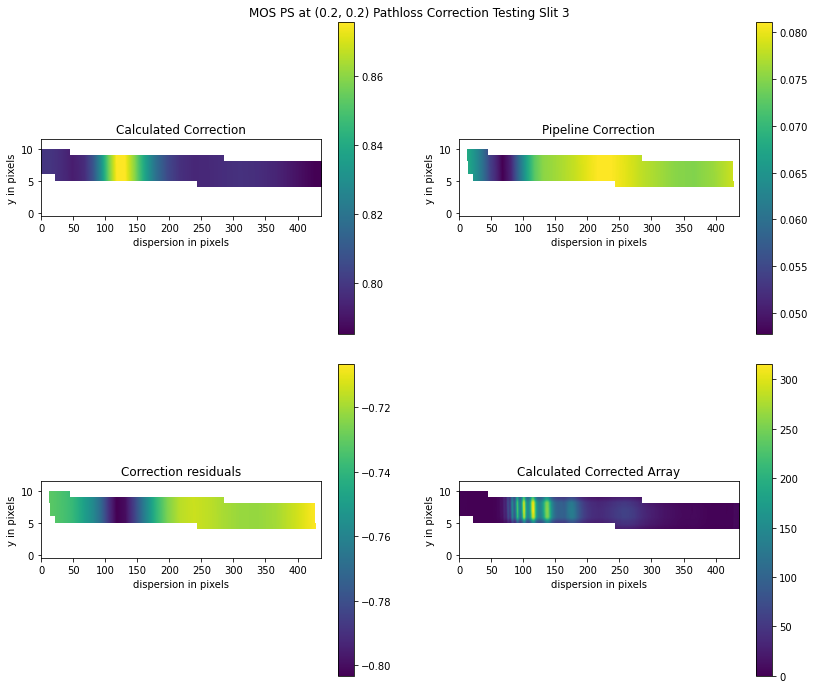

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  4
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


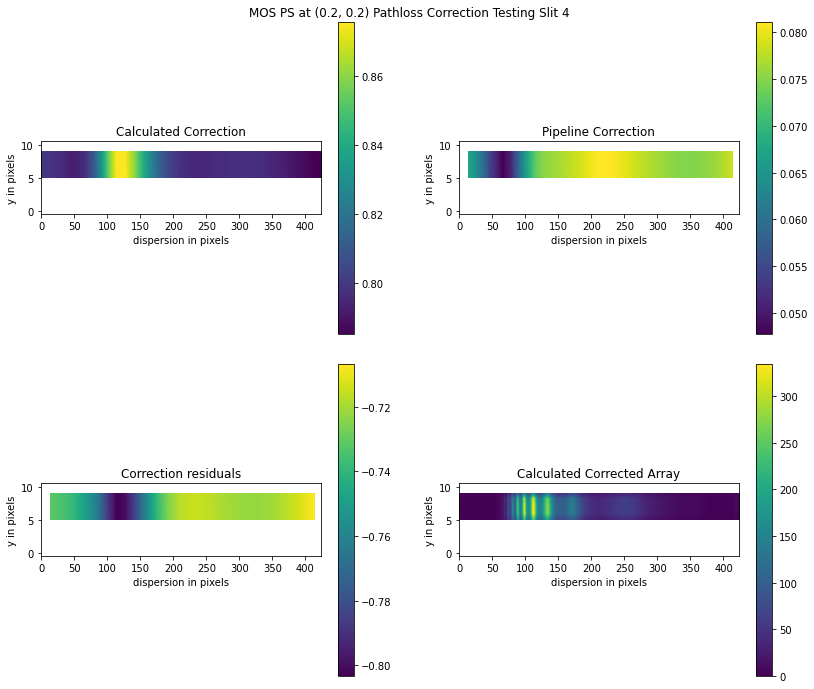

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED


 *** Final pathloss test result reported as FAILED *** 

('* Script MSA.py took ', '2.0238380432128906 seconds to finish.')
Did pathloss validation test passed?  One or more slits FAILED path_loss test. 


Testing files for detector:  nrs2
Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc/mos_prism_nrs2_uncal.fits


2021-03-24 16:04:17,460 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2021-03-24 16:04:17,473 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-03-24 16:04:17,475 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-03-24 16:04:17,477 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-03-24 16:04:17,478 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-03-24 16:04:17,479 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-03-24 16:04:17,481 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-03-24 16:04:17,482 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-03-24 16:04:17,483 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-03-24 16:04:17,485 - stpipe.Detector1

2021-03-24 16:04:17,709 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0011.fits'.
2021-03-24 16:04:17,710 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-03-24 16:04:17,710 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0017.fits'.
2021-03-24 16:04:17,711 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0020.fits'.
2021-03-24 16:04:17,712 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-03-24 16:04:17,712 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-03-24 16:04:17,713 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jw

2021-03-24 16:04:19,893 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-03-24 16:04:19,917 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0020.fits
2021-03-24 16:04:29,877 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2021-03-24 16:04:30,127 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).
2021-03-24 16:04:30,129 - stpipe.De

MSA shutter configuration file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc/V0030006000104_msa.fits


2021-03-24 16:04:48,730 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1
2021-03-24 16:04:48,749 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg
2021-03-24 16:04:48,750 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg
2021-03-24 16:04:48,751 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg
2021-03-24 16:04:48,752 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg
2021-03-24 16:04:48,980 - stpipe.AssignWcsStep - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-03-24 16:04:49,016 - stpipe.AssignWcsStep - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-03-24 16:04:49,017 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: []
2021-03-24 16:04:49,017 - stpipe.AssignWcsStep - CRITICAL - No open slits f

An error occurred that made the pipeline crash, probably: No open slits fall on detector  nrs2
Skipping test for this file. 

Did pathloss validation test passed?  skipped 


Testing files for detector:  nrs1
Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc/mos_g140m_line1_NRS1_uncal.fits


2021-03-24 16:04:59,064 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2021-03-24 16:04:59,077 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-03-24 16:04:59,078 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-03-24 16:04:59,080 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-03-24 16:04:59,081 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-03-24 16:04:59,083 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-03-24 16:04:59,084 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-03-24 16:04:59,085 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-03-24 16:04:59,087 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-03-24 16:04:59,088 - stpipe.Detector1

2021-03-24 16:04:59,315 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0024.fits'.
2021-03-24 16:04:59,316 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-03-24 16:04:59,317 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0019.fits'.
2021-03-24 16:04:59,317 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-03-24 16:04:59,318 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-03-24 16:04:59,318 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-03-24 16:04:59,319 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0023.fits'.
2021-03-24 16:04:59,319 - stpipe.Detect

2021-03-24 16:05:04,584 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0140.fits
2021-03-24 16:05:04,908 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0
2021-03-24 16:05:04,908 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0
2021-03-24 16:05:05,035 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2021-03-24 16:05:05,157 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).
2021-03-24 16:05:05,158 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output

MSA shutter configuration file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc/V8460001000101_msa.fits


2021-03-24 16:05:33,100 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1
2021-03-24 16:05:33,335 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg
2021-03-24 16:05:33,335 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg
2021-03-24 16:05:33,336 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg
2021-03-24 16:05:33,337 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg
2021-03-24 16:05:33,516 - stpipe.AssignWcsStep - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-03-24 16:05:33,532 - stpipe.AssignWcsStep - INFO - Removing slit 7 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-03-24 16:05:33,551 - stpipe.AssignWcsStep - INFO - Removing slit 8 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-

2021-03-24 16:05:34,935 - stpipe.AssignWcsStep - INFO - There are 4 open slits in quadrant 3
2021-03-24 16:05:34,973 - stpipe.AssignWcsStep - INFO - There are 10 open slits in quadrant 4
2021-03-24 16:05:35,064 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5
2021-03-24 16:05:35,342 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf', 'collimator': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0004.asdf', 'disperser': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0032.asdf', 'fore': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0023.asdf', 'fpa': '/Users/pena/crds_cache/references/jwst/nirspec

2021-03-24 16:05:51,831 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1969 2048
2021-03-24 16:05:51,831 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 404 420
2021-03-24 16:05:51,948 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-03-24 16:05:51,958 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.218718991 -45.644595818 156.218591488 -45.644475376 156.218529475 -45.644506992 156.218656977 -45.644627436
2021-03-24 16:05:51,958 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.218718991 -45.644595818 156.218591488 -45.644475376 156.218529475 -45.644506992 156.218656977 -45.644627436
2021-03-24 16:05:52,607 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 45
2021-03-24 16:05:52,607 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1908 2048
2021-03-24 16:05:52,608 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 530 546
2021-03-24 16:05:52,728 - stpipe.Extract2dStep - INFO - set slit_att

2021-03-24 16:06:00,028 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 66
2021-03-24 16:06:00,029 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 426 1892
2021-03-24 16:06:00,029 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1452 1474
2021-03-24 16:06:00,167 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-03-24 16:06:00,176 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.192290190 -45.696194513 156.192162195 -45.696070854 156.192099979 -45.696103094 156.192227972 -45.696226755
2021-03-24 16:06:00,177 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.192290190 -45.696194513 156.192162195 -45.696070854 156.192099979 -45.696103094 156.192227972 -45.696226755
2021-03-24 16:06:00,856 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 68
2021-03-24 16:06:00,856 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 375 1842
2021-03-24 16:06:00,856 - stpipe.Extract2dStep - INFO - Subarray y-ex

2021-03-24 16:06:08,195 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 67
2021-03-24 16:06:08,196 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 328 1789
2021-03-24 16:06:08,196 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 130 150
2021-03-24 16:06:08,327 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-03-24 16:06:08,336 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.158533940 -45.665758025 156.158408563 -45.665637125 156.158346784 -45.665669007 156.158472159 -45.665789909
2021-03-24 16:06:08,336 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.158533940 -45.665758025 156.158408563 -45.665637125 156.158346784 -45.665669007 156.158472159 -45.665789909
2021-03-24 16:06:09,465 - stpipe.Extract2dStep - INFO - Step Extract2dStep done
2021-03-24 16:06:12,596 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2021-03-24 16:06:12,781 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep 

2021-03-24 16:06:55,522 - stpipe.PathLossStep - INFO - Working on slit 3
2021-03-24 16:06:55,536 - stpipe.PathLossStep - INFO - Working on slit 4
2021-03-24 16:06:55,551 - stpipe.PathLossStep - INFO - Working on slit 5
2021-03-24 16:06:55,567 - stpipe.PathLossStep - INFO - Working on slit 6
2021-03-24 16:06:55,582 - stpipe.PathLossStep - INFO - Working on slit 7
2021-03-24 16:06:55,597 - stpipe.PathLossStep - INFO - Working on slit 8
2021-03-24 16:06:55,612 - stpipe.PathLossStep - INFO - Working on slit 9
2021-03-24 16:06:55,628 - stpipe.PathLossStep - INFO - Working on slit 10
2021-03-24 16:06:55,643 - stpipe.PathLossStep - INFO - Working on slit 11
2021-03-24 16:06:55,658 - stpipe.PathLossStep - INFO - Working on slit 12
2021-03-24 16:06:55,673 - stpipe.PathLossStep - INFO - Working on slit 13
2021-03-24 16:06:55,690 - stpipe.PathLossStep - INFO - Working on slit 14
2021-03-24 16:06:55,707 - stpipe.PathLossStep - INFO - Working on slit 15
2021-03-24 16:06:55,724 - stpipe.PathLossStep

Running test for MOS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: G140M   Filter: F100LP   Lamp: LINE1   EXP_TYPE: NRS_MSASPEC
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0002.fits
Retrieving exensions
Looping through the slits... 
Retrieved point source extension 1
Working with slitlet  53
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


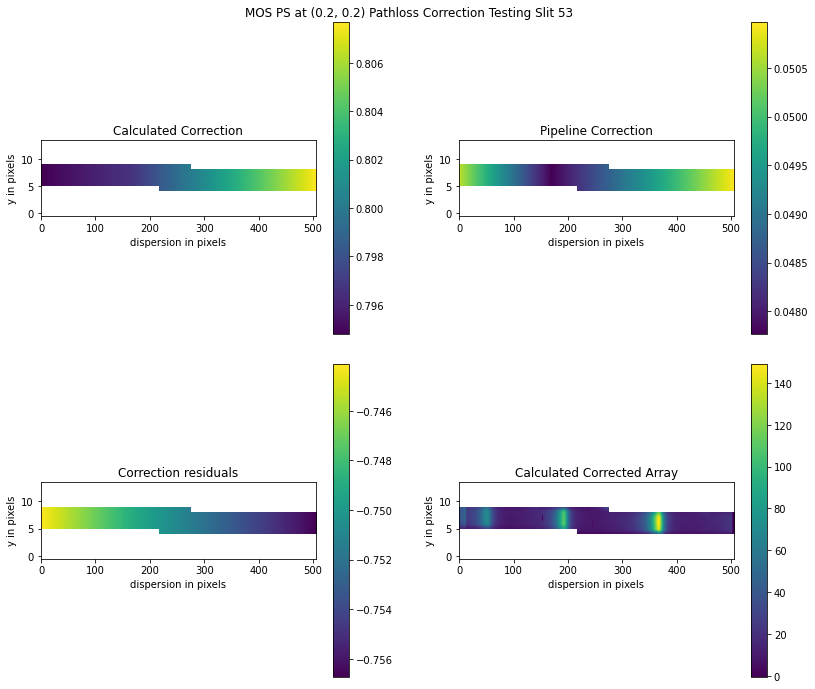

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  54
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


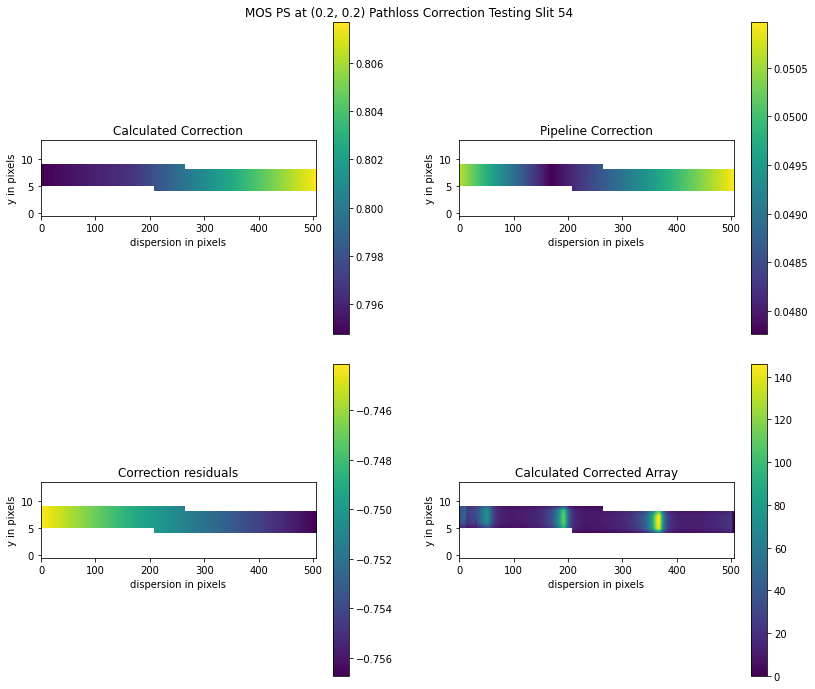

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  42
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


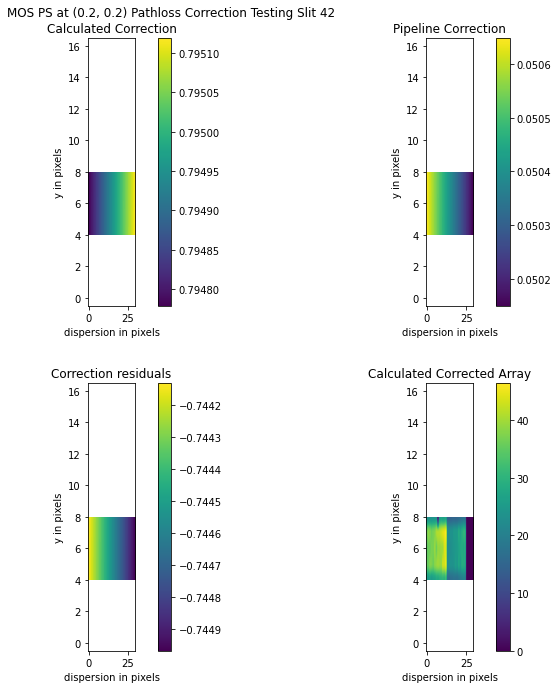

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  43
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


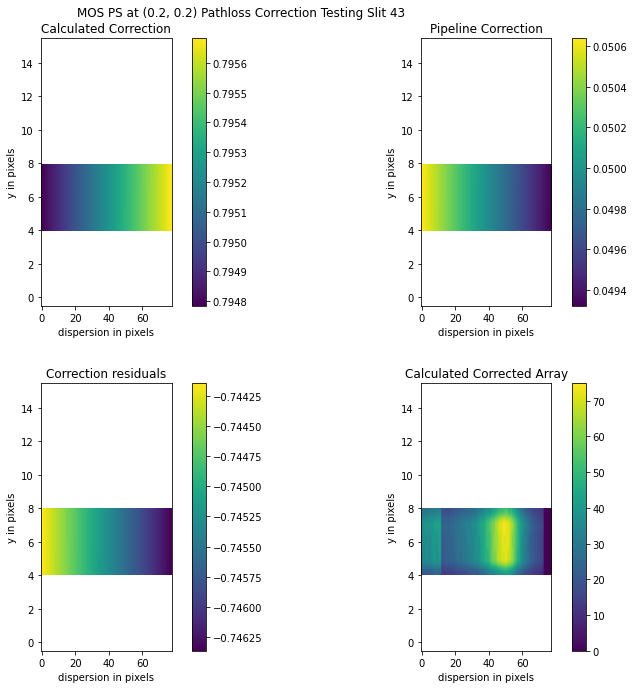

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  44
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


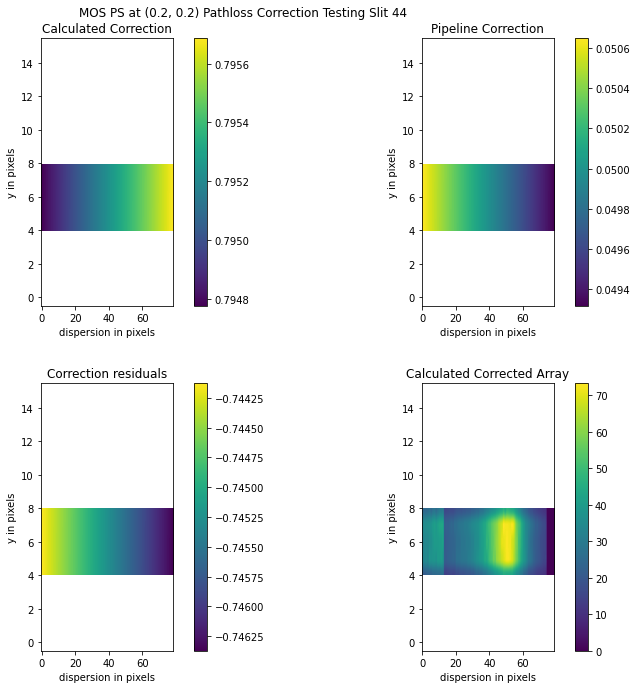

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  45
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


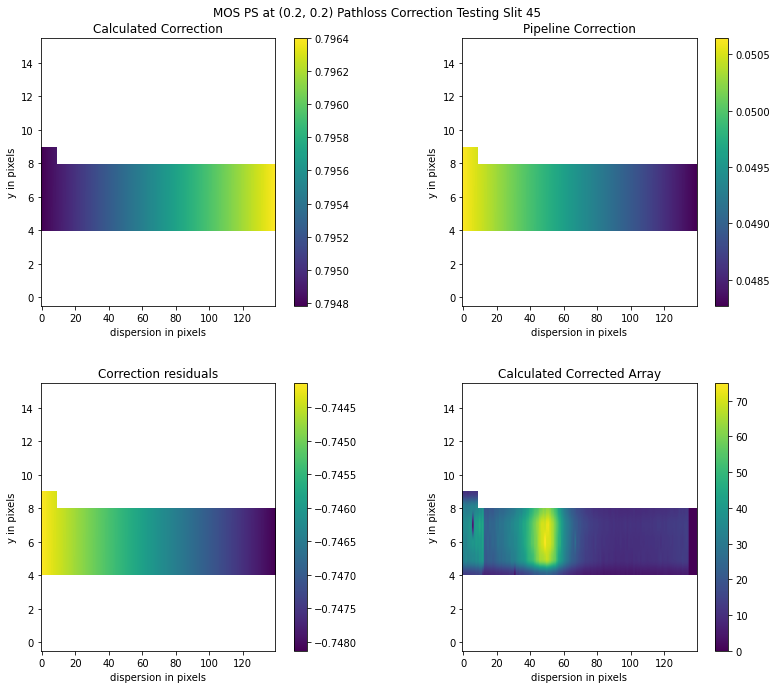

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  46
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


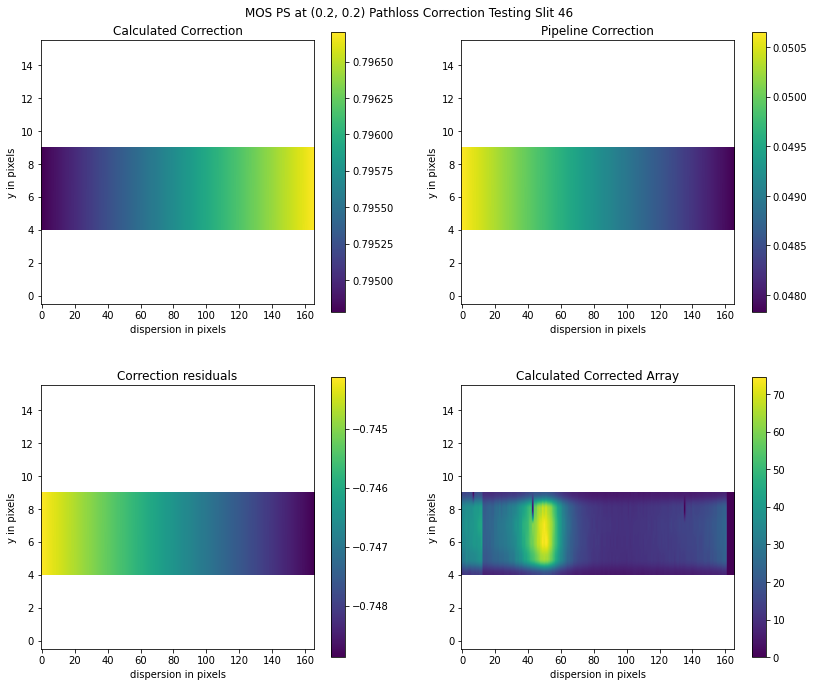

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  47
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


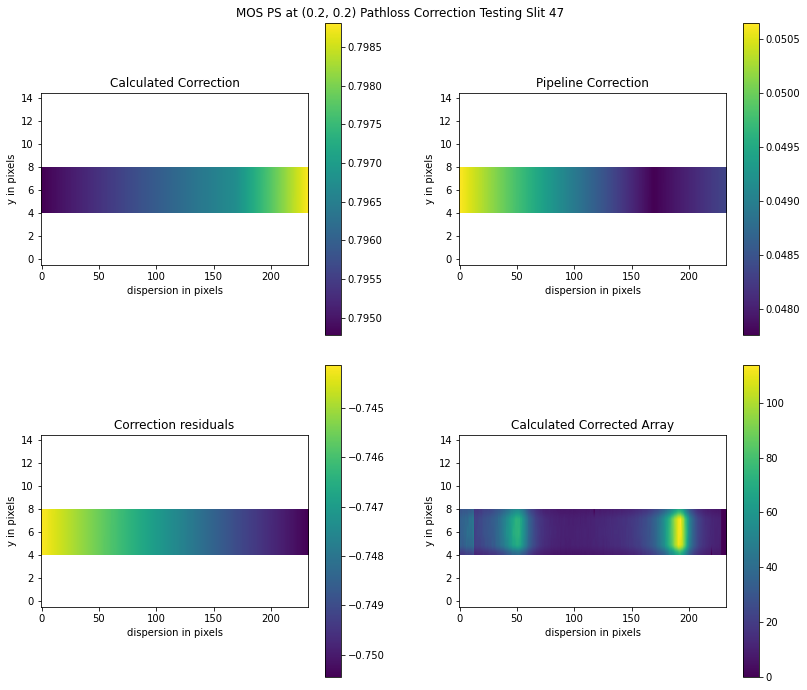

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  48
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


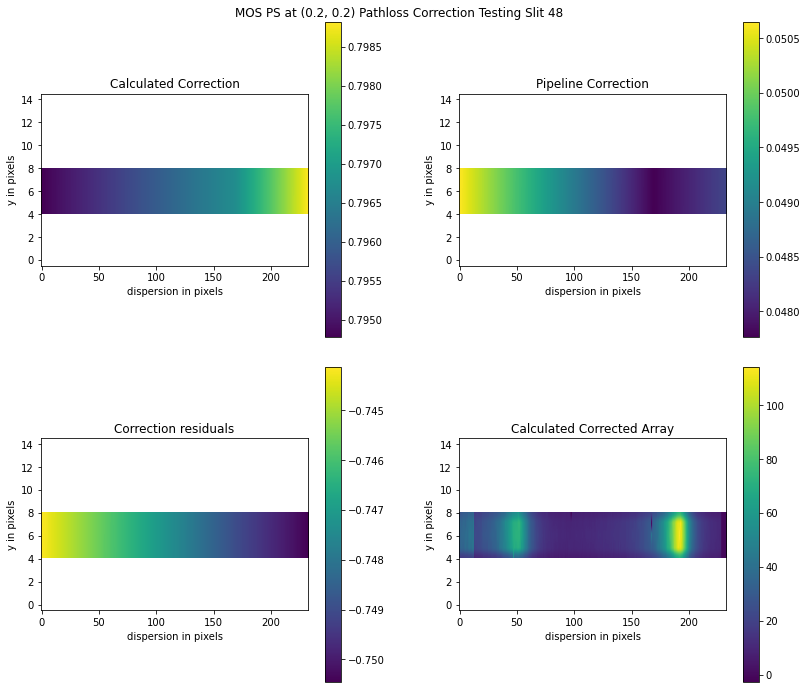

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  49
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


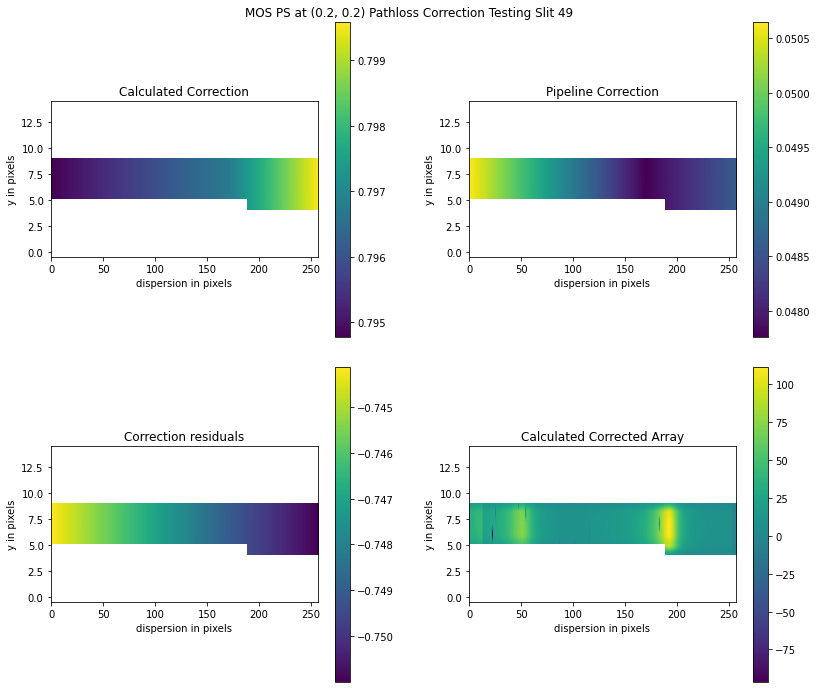

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  50
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


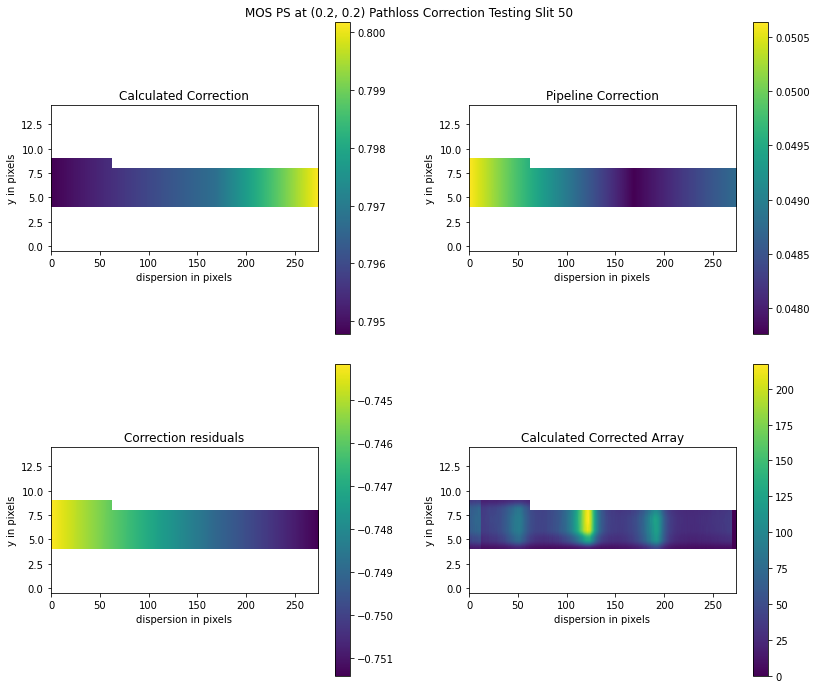

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  51
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


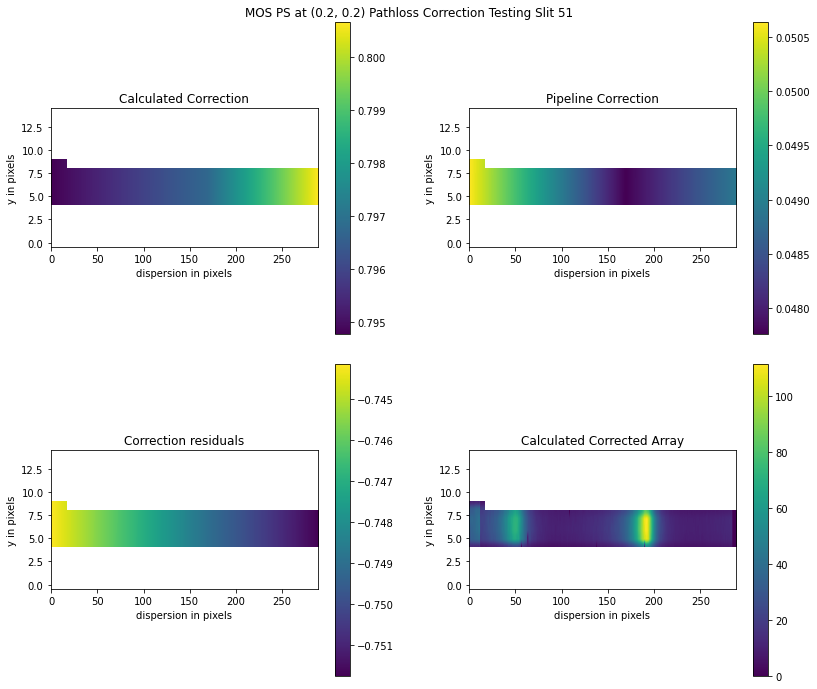

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  52
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


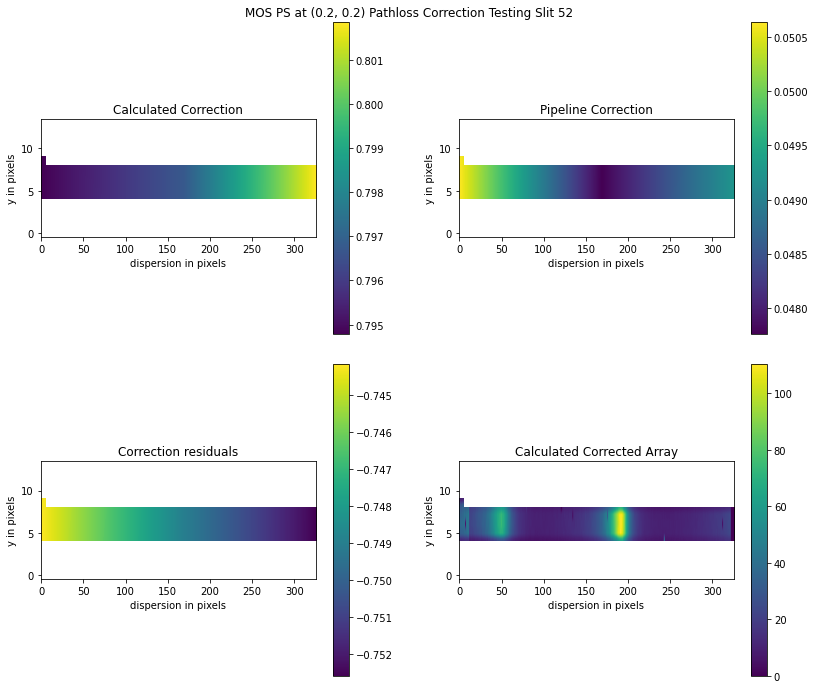

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  55
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


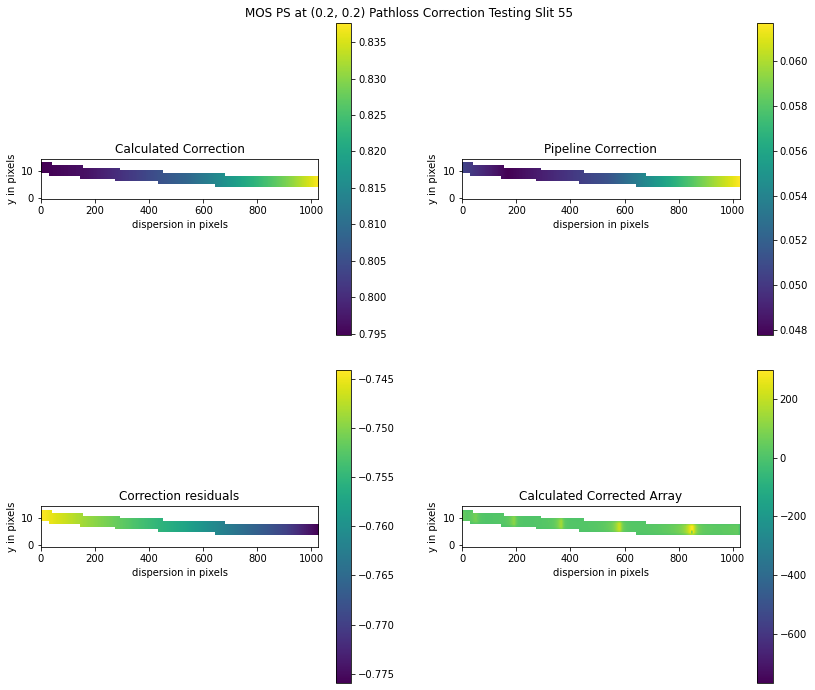

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  65
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


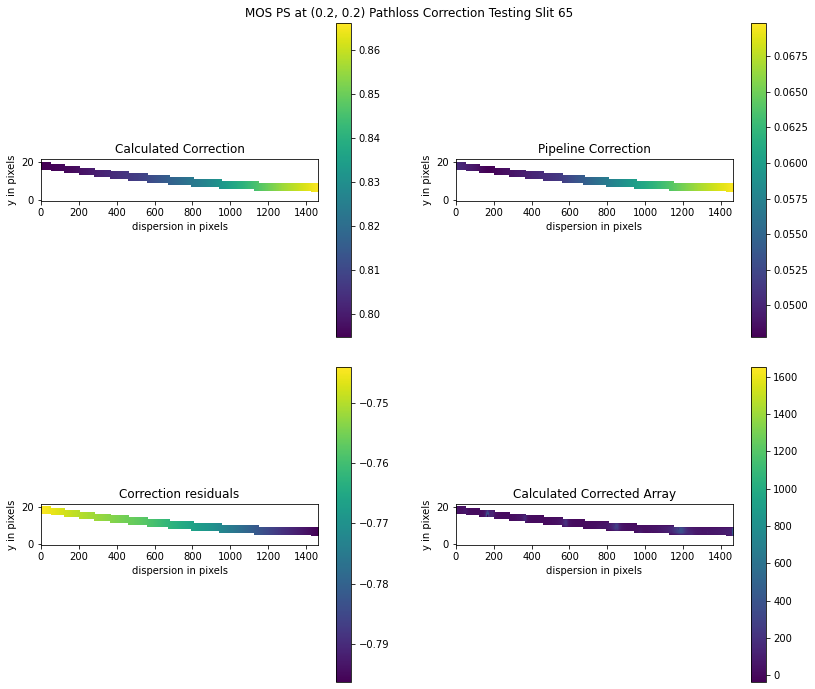

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  66
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


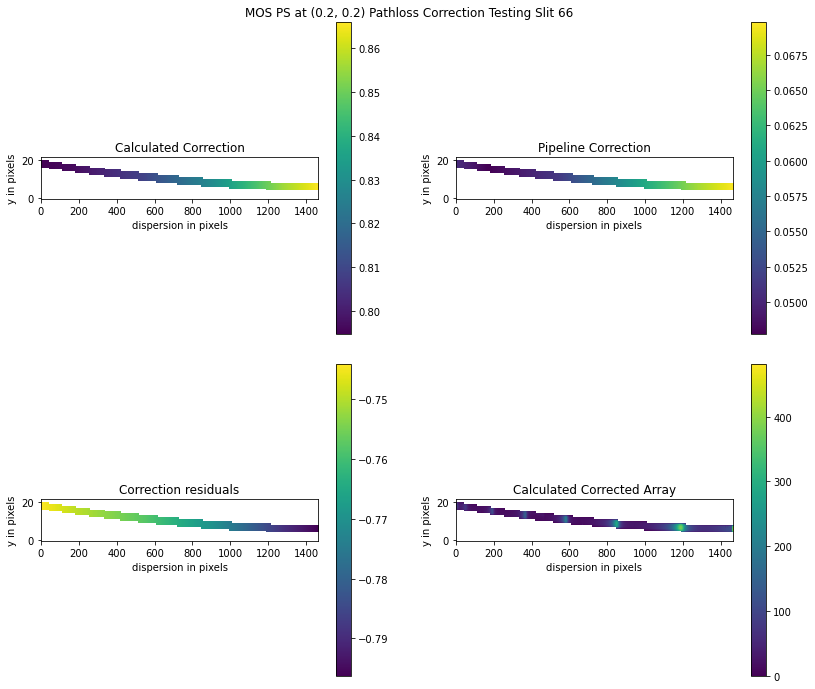

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  68
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


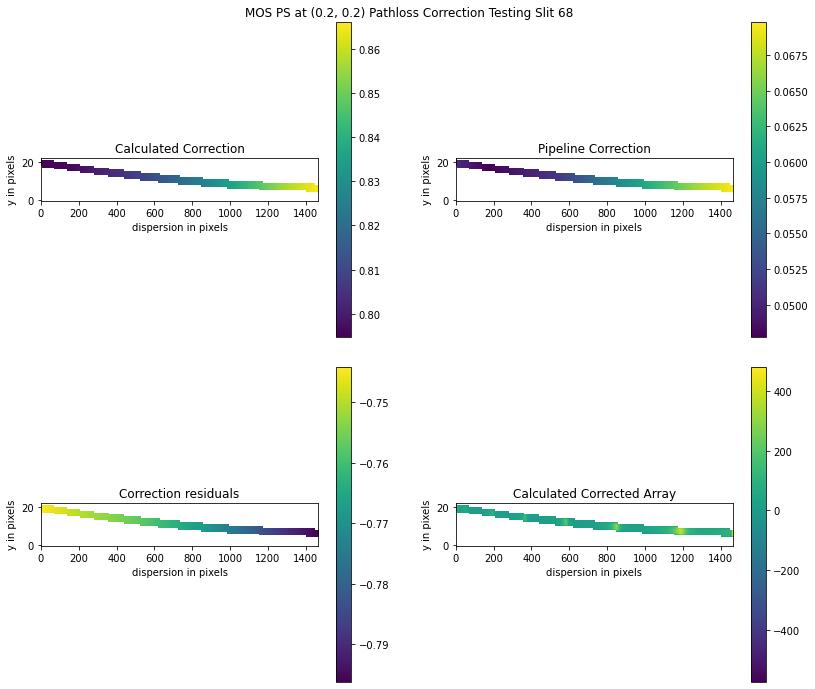

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  56
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


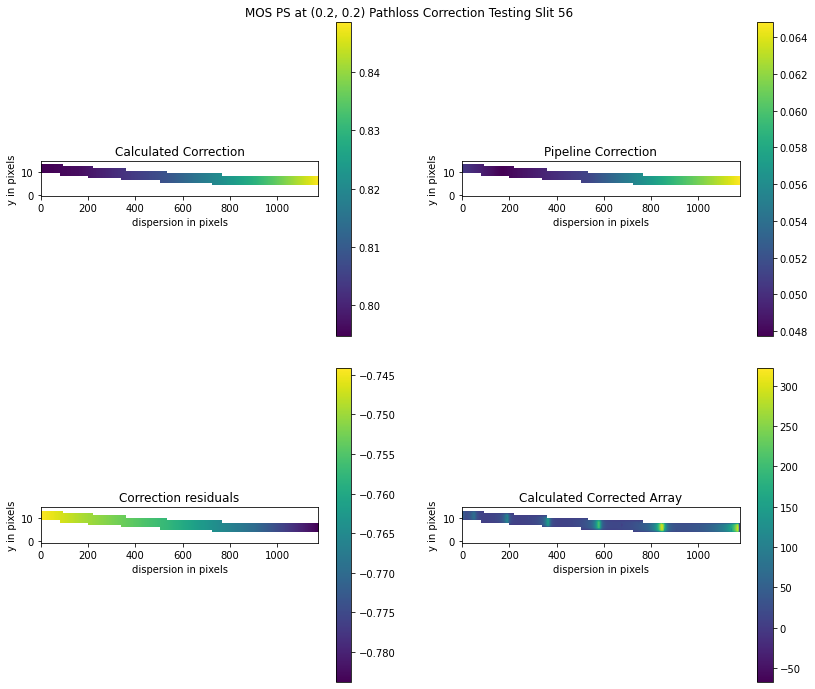

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  57
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


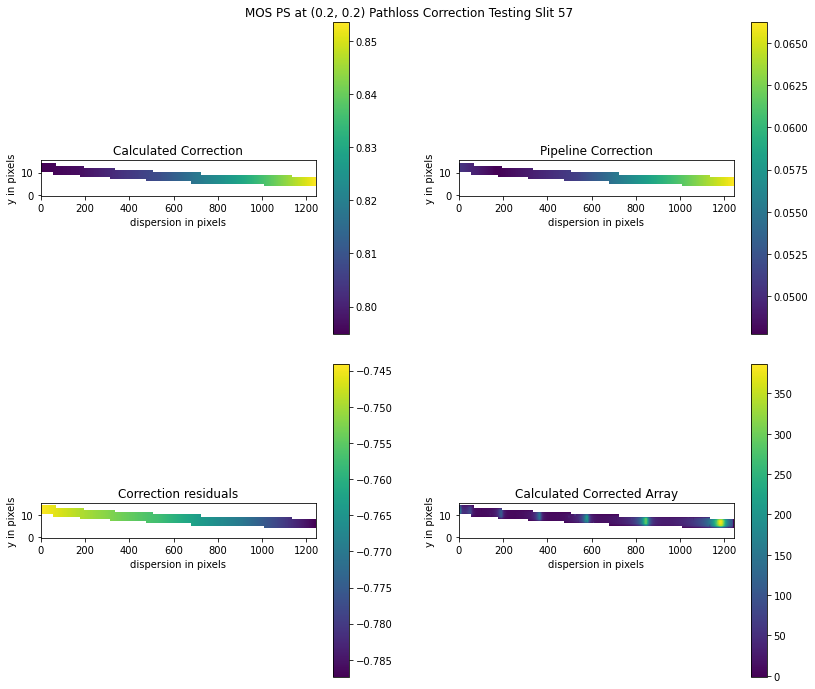

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  58
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


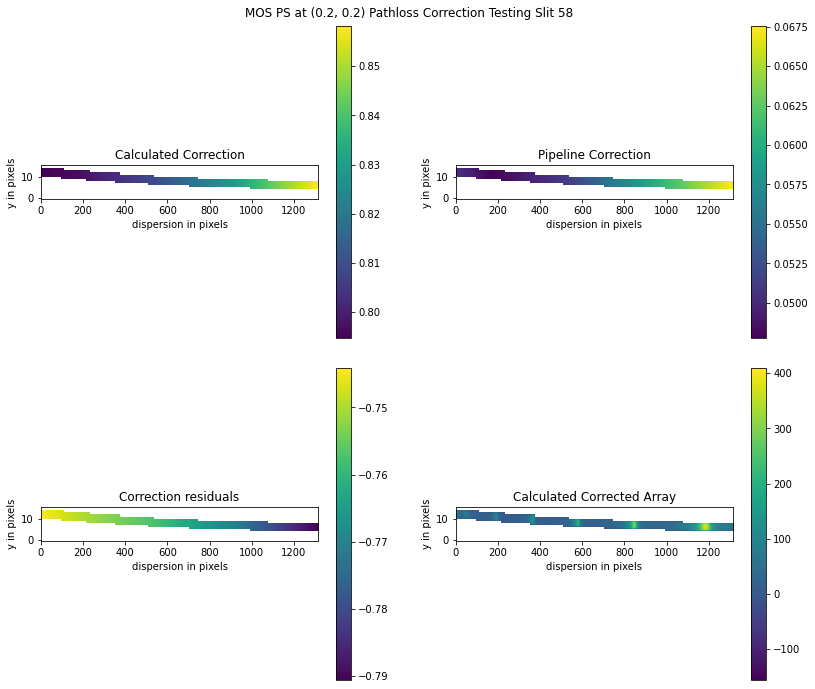

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  59
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


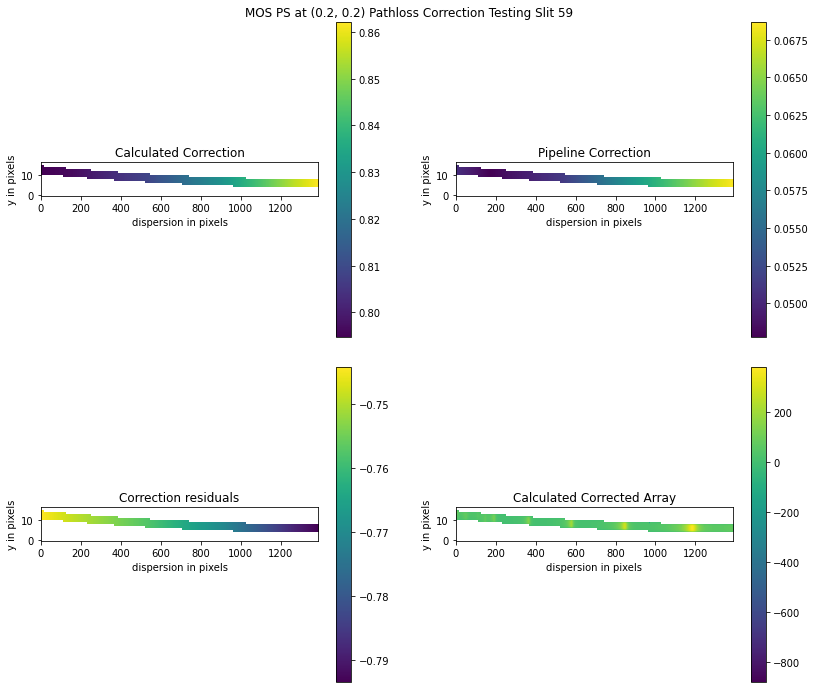

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  60
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


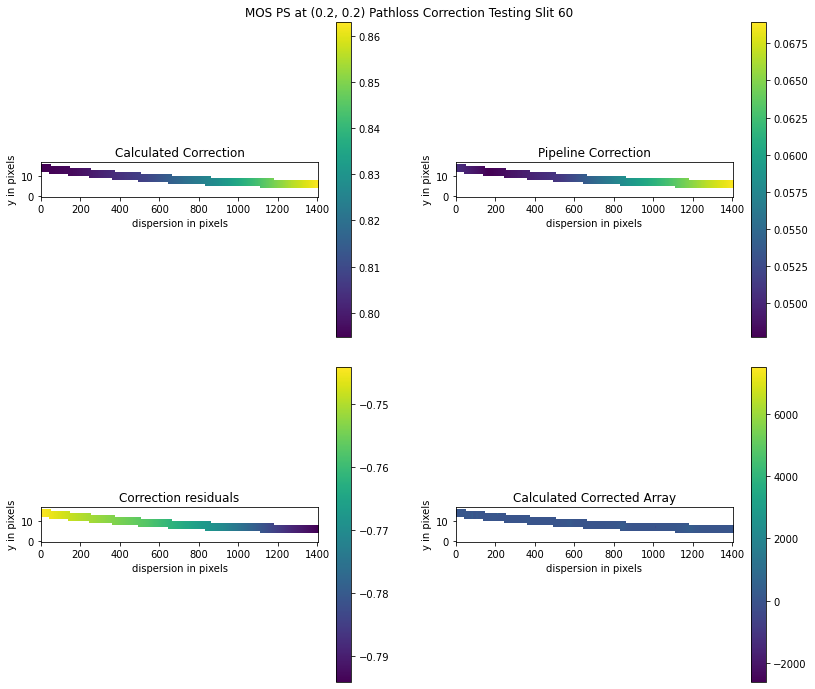

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  61
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


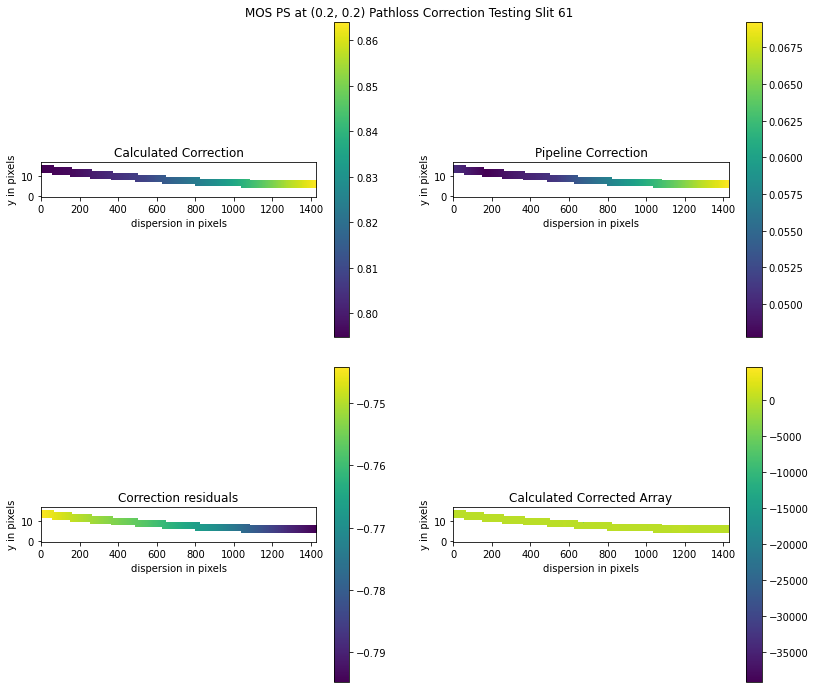

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  62
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


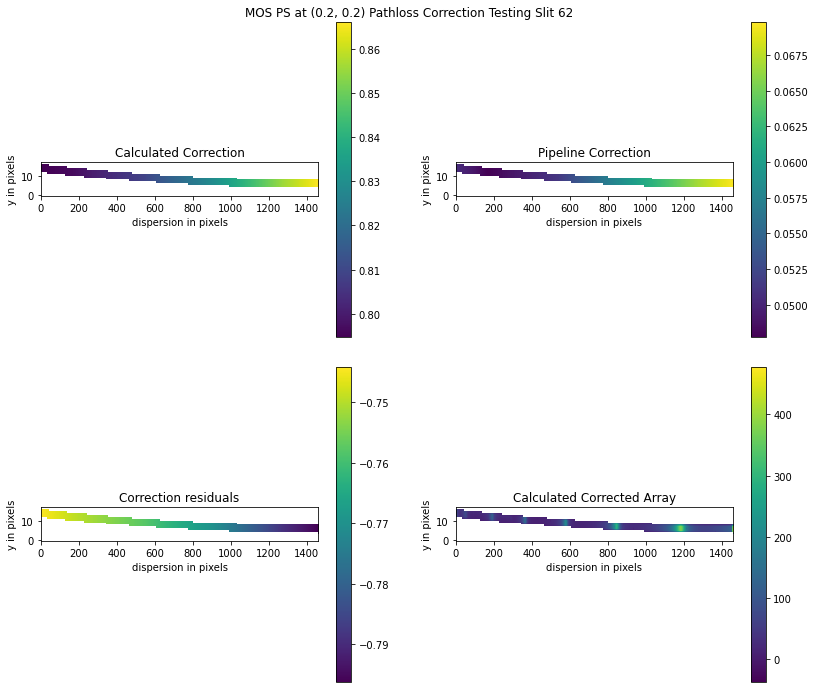

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  63
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


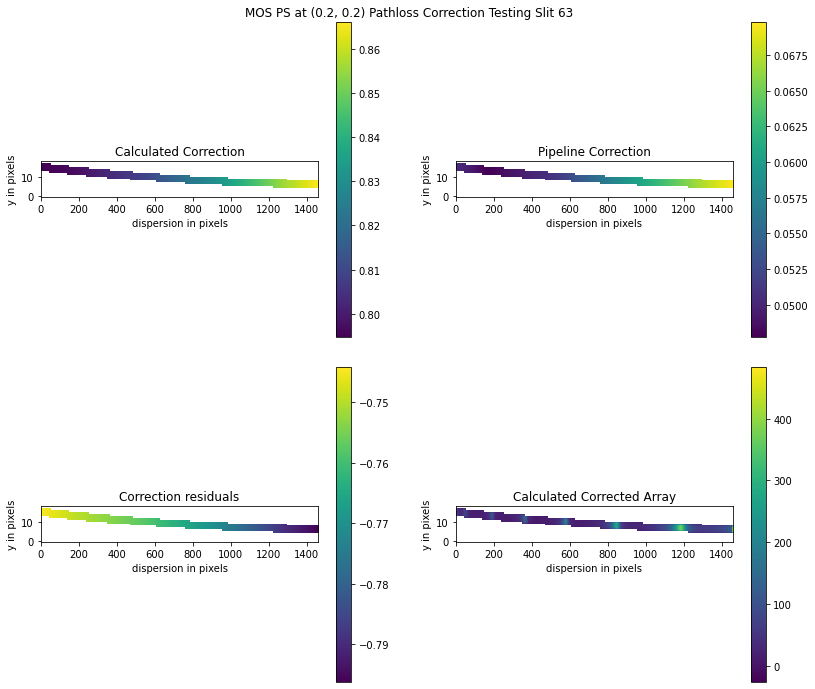

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  64
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


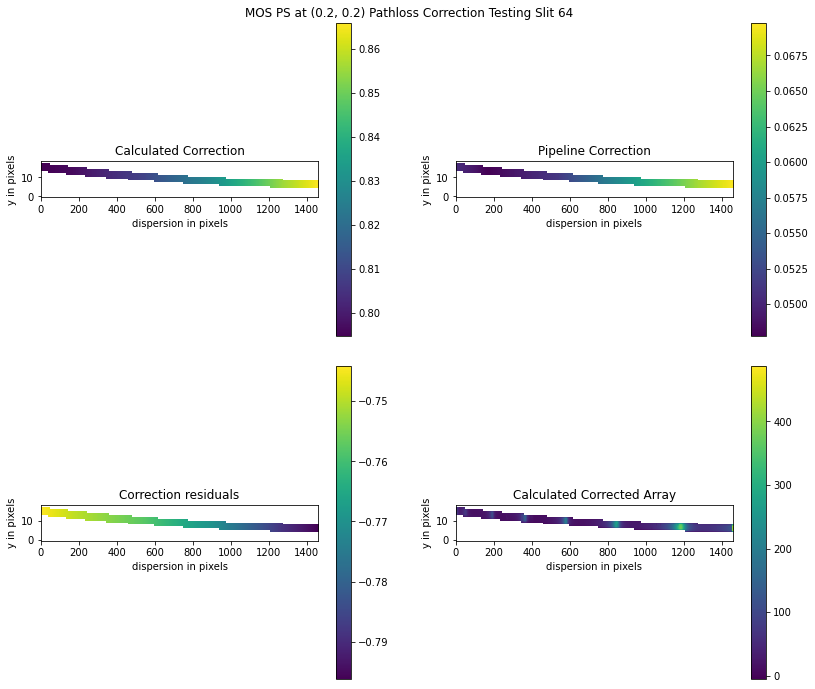

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  67
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


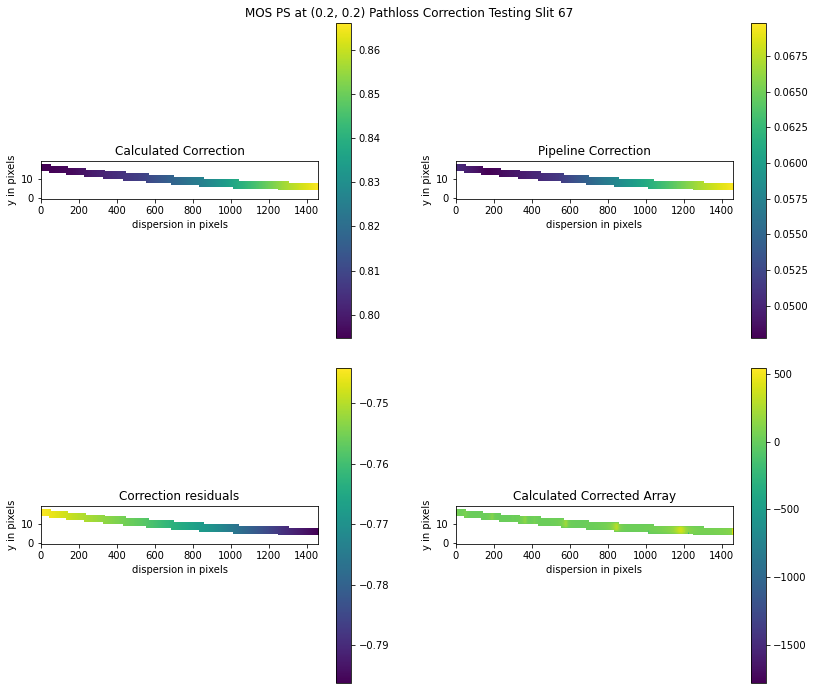

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED


 *** Final pathloss test result reported as FAILED *** 

('* Script MSA.py took ', '29.33400869369507 seconds to finish.')
Did pathloss validation test passed?  One or more slits FAILED path_loss test. 


Testing files for detector:  nrs2
Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc/mos_g140m_line1_NRS2_uncal.fits


2021-03-24 16:07:35,361 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2021-03-24 16:07:35,375 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-03-24 16:07:35,376 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-03-24 16:07:35,378 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-03-24 16:07:35,379 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-03-24 16:07:35,381 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-03-24 16:07:35,382 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-03-24 16:07:35,383 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-03-24 16:07:35,385 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-03-24 16:07:35,386 - stpipe.Detector1

2021-03-24 16:07:35,815 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0025.fits'.
2021-03-24 16:07:35,816 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-03-24 16:07:35,816 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0016.fits'.
2021-03-24 16:07:35,817 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-03-24 16:07:35,818 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-03-24 16:07:35,818 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-03-24 16:07:35,819 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0022.fits'.
2021-03-24 16:07:35,819 - stpipe.Detect

2021-03-24 16:07:42,415 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0143.fits
2021-03-24 16:07:42,716 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0
2021-03-24 16:07:42,716 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0
2021-03-24 16:07:42,830 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2021-03-24 16:07:43,121 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).
2021-03-24 16:07:43,123 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output

MSA shutter configuration file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmpickc9mnc/V8460001000101_msa.fits


2021-03-24 16:08:10,279 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).
2021-03-24 16:08:10,281 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-03-24 16:08:10,464 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1
2021-03-24 16:08:10,710 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg
2021-03-24 16:08:10,711 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg
2

2021-03-24 16:08:28,508 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)
2021-03-24 16:08:29,654 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 6
2021-03-24 16:08:29,654 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 138 1619
2021-03-24 16:08:29,655 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1761 

2021-03-24 16:08:43,297 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 18
2021-03-24 16:08:43,298 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 115 1597
2021-03-24 16:08:43,298 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1846 1870
2021-03-24 16:08:43,437 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-03-24 16:08:43,447 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.264461421 -45.673776492 156.264329887 -45.673653347 156.264267013 -45.673685227 156.264398544 -45.673808373
2021-03-24 16:08:43,448 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.264461421 -45.673776492 156.264329887 -45.673653347 156.264267013 -45.673685227 156.264398544 -45.673808373
2021-03-24 16:08:44,717 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 19
2021-03-24 16:08:44,718 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 93 1571
2021-03-24 16:08:44,718 - stpipe.Extract2dStep - INFO - Subarray y-ext

2021-03-24 16:08:58,234 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 37
2021-03-24 16:08:58,235 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1412
2021-03-24 16:08:58,235 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1663 1683
2021-03-24 16:08:58,371 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-03-24 16:08:58,381 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.253937935 -45.672305027 156.253807112 -45.672182158 156.253744431 -45.672214010 156.253875252 -45.672336880
2021-03-24 16:08:58,381 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.253937935 -45.672305027 156.253807112 -45.672182158 156.253744431 -45.672214010 156.253875252 -45.672336880
2021-03-24 16:08:59,366 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 38
2021-03-24 16:08:59,366 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1404
2021-03-24 16:08:59,367 - stpipe.Extract2dStep - INFO - Subarray y-extent

2021-03-24 16:09:12,677 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 12
2021-03-24 16:09:12,678 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 91 1566
2021-03-24 16:09:12,678 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 483 503
2021-03-24 16:09:12,807 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-03-24 16:09:12,816 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.230998580 -45.641224458 156.230870498 -45.641103991 156.230808285 -45.641135623 156.230936364 -45.641256090
2021-03-24 16:09:12,817 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.230998580 -45.641224458 156.230870498 -45.641103991 156.230808285 -45.641135623 156.230936364 -45.641256090
2021-03-24 16:09:14,267 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 13
2021-03-24 16:09:14,268 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 80 1553
2021-03-24 16:09:14,268 - stpipe.Extract2dStep - INFO - Subarray y-extent

2021-03-24 16:09:27,836 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 42
2021-03-24 16:09:27,837 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1296
2021-03-24 16:09:27,838 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 545 562
2021-03-24 16:09:27,970 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-03-24 16:09:27,980 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.223646010 -45.647128995 156.223518121 -45.647008321 156.223456024 -45.647039957 156.223583911 -45.647160632
2021-03-24 16:09:27,981 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.223646010 -45.647128995 156.223518121 -45.647008321 156.223456024 -45.647039957 156.223583911 -45.647160632
2021-03-24 16:09:28,956 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 43
2021-03-24 16:09:28,957 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1246
2021-03-24 16:09:28,957 - stpipe.Extract2dStep - INFO - Subarray y-extents 

2021-03-24 16:09:42,046 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 55
2021-03-24 16:09:42,047 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 297
2021-03-24 16:09:42,047 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1415 1430
2021-03-24 16:09:42,166 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-03-24 16:09:42,175 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.211226719 -45.684941334 156.211098073 -45.684818233 156.211035880 -45.684850241 156.211164524 -45.684973343
2021-03-24 16:09:42,176 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.211226719 -45.684941334 156.211098073 -45.684818233 156.211035880 -45.684850241 156.211164524 -45.684973343
2021-03-24 16:09:43,624 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 56
2021-03-24 16:09:43,625 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 143
2021-03-24 16:09:43,625 - stpipe.Extract2dStep - INFO - Subarray y-extents 

2021-03-24 16:09:50,900 - stpipe.SourceTypeStep - INFO - source_id=49, stellarity=0.0000, type=EXTENDED
2021-03-24 16:09:50,900 - stpipe.SourceTypeStep - INFO - source_id=50, stellarity=0.0000, type=EXTENDED
2021-03-24 16:09:50,901 - stpipe.SourceTypeStep - INFO - source_id=51, stellarity=0.0000, type=EXTENDED
2021-03-24 16:09:50,902 - stpipe.SourceTypeStep - INFO - source_id=52, stellarity=0.0000, type=EXTENDED
2021-03-24 16:09:50,902 - stpipe.SourceTypeStep - INFO - source_id=55, stellarity=0.0000, type=EXTENDED
2021-03-24 16:09:50,903 - stpipe.SourceTypeStep - INFO - source_id=56, stellarity=0.0000, type=EXTENDED
2021-03-24 16:09:50,904 - stpipe.SourceTypeStep - INFO - source_id=57, stellarity=0.0000, type=EXTENDED
2021-03-24 16:09:50,905 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done
2021-03-24 16:09:51,041 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2021-03-24 16:09:51,485 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSl

2021-03-24 16:11:48,624 - stpipe.PathLossStep - INFO - Working on slit 21
2021-03-24 16:11:48,639 - stpipe.PathLossStep - INFO - Working on slit 22
2021-03-24 16:11:48,655 - stpipe.PathLossStep - INFO - Working on slit 23
2021-03-24 16:11:48,671 - stpipe.PathLossStep - INFO - Working on slit 24
2021-03-24 16:11:48,686 - stpipe.PathLossStep - INFO - Working on slit 25
2021-03-24 16:11:48,701 - stpipe.PathLossStep - INFO - Working on slit 26
2021-03-24 16:11:48,716 - stpipe.PathLossStep - INFO - Working on slit 27
2021-03-24 16:11:48,732 - stpipe.PathLossStep - INFO - Working on slit 28
2021-03-24 16:11:48,748 - stpipe.PathLossStep - INFO - Working on slit 29
2021-03-24 16:11:48,763 - stpipe.PathLossStep - INFO - Working on slit 30
2021-03-24 16:11:48,779 - stpipe.PathLossStep - INFO - Working on slit 31
2021-03-24 16:11:48,794 - stpipe.PathLossStep - INFO - Working on slit 32
2021-03-24 16:11:48,809 - stpipe.PathLossStep - INFO - Working on slit 33
2021-03-24 16:11:48,824 - stpipe.PathL

Running test for MOS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS2   Grating: G140M   Filter: F100LP   Lamp: LINE1   EXP_TYPE: NRS_MSASPEC
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0002.fits
Retrieving exensions
Looping through the slits... 
Retrieved point source extension 1
Working with slitlet  6
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


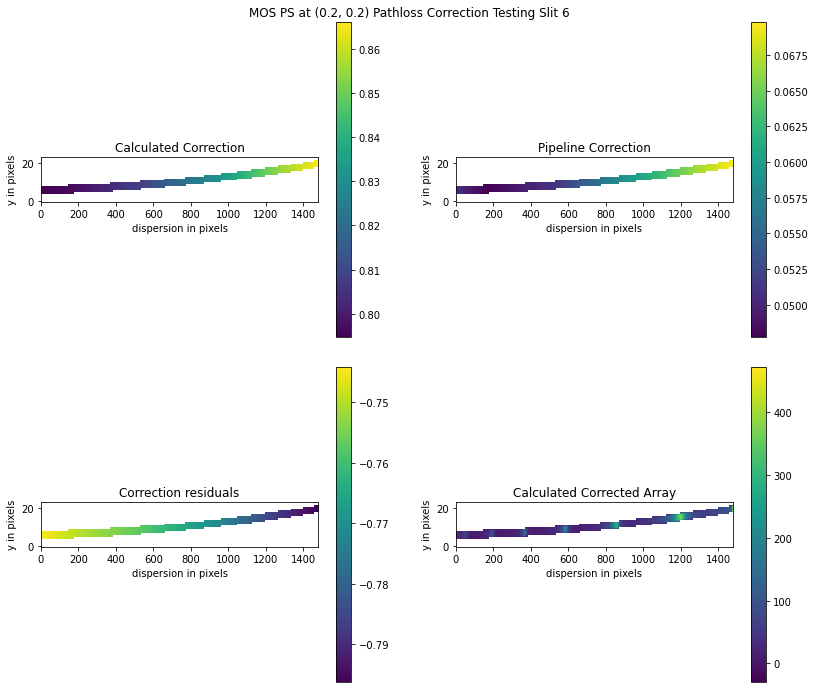

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  7
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


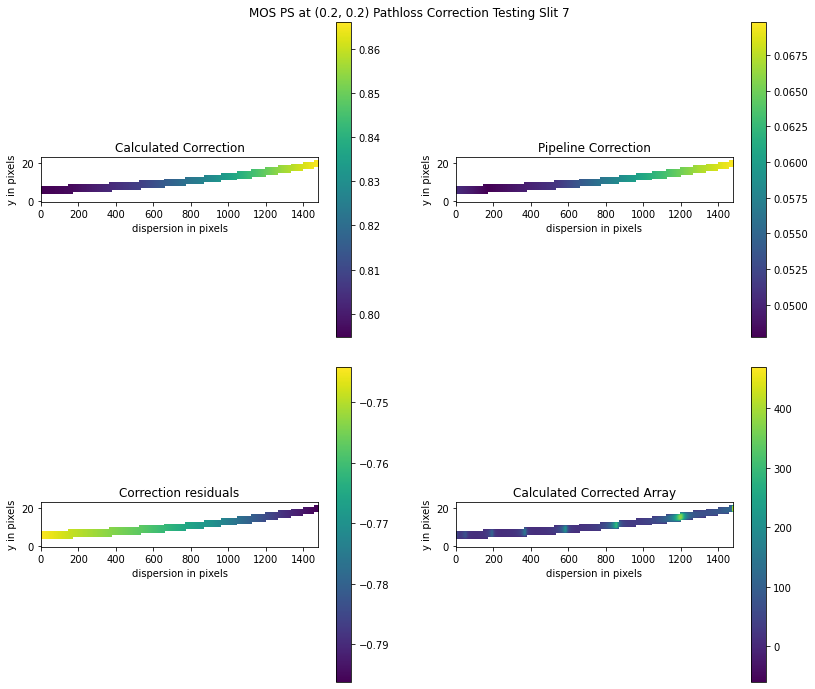

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  8
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


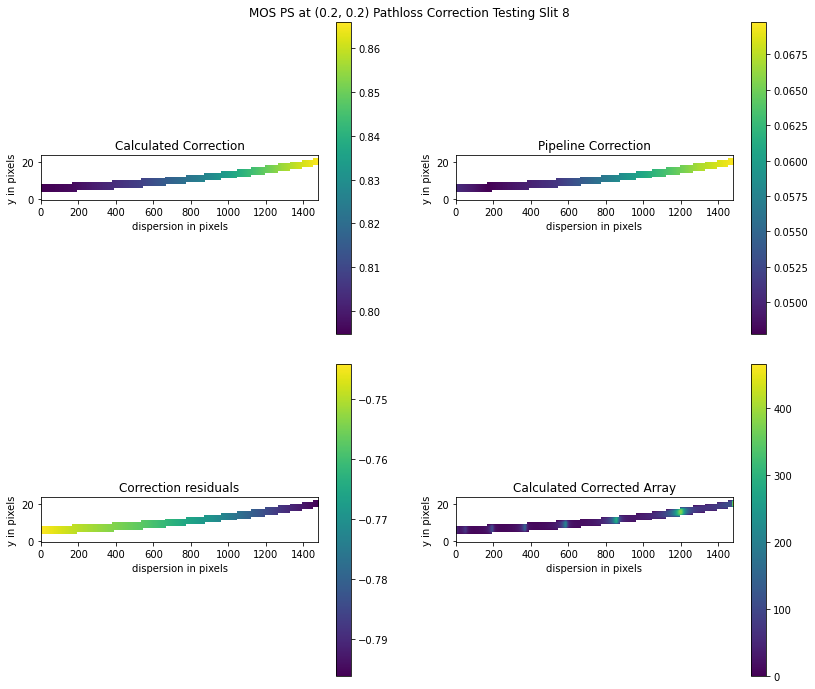

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  9
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


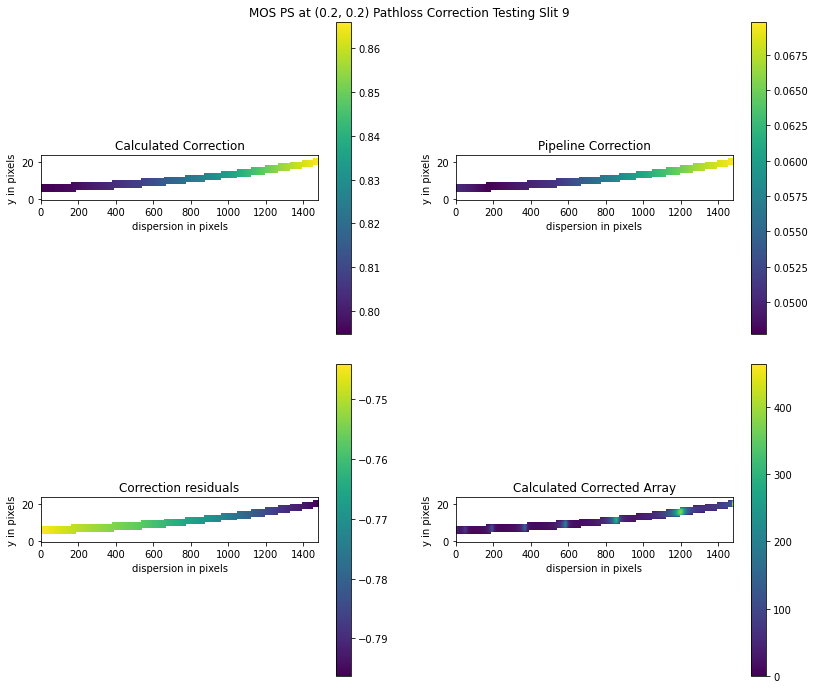

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  10
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


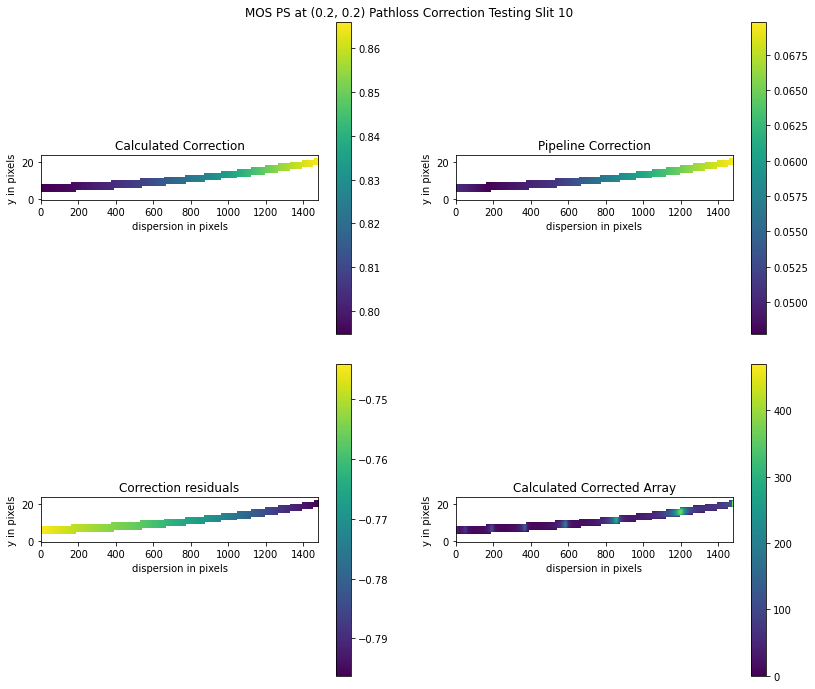

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  11
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


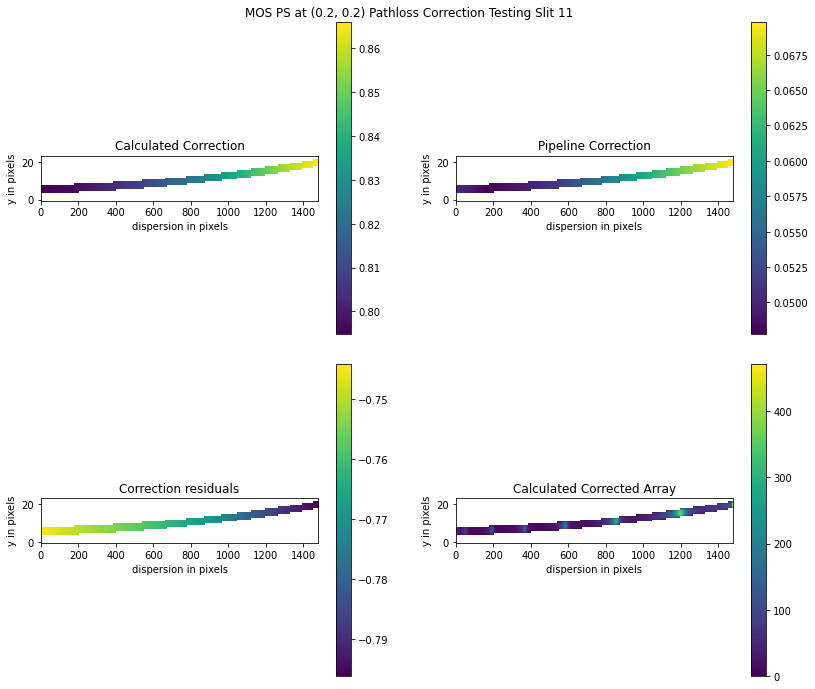

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  14
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


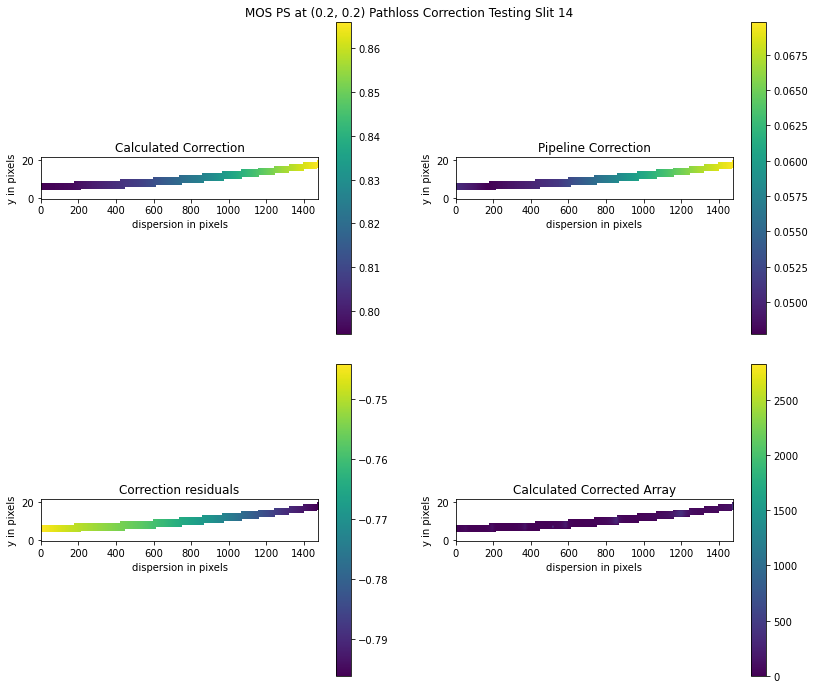

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  15
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


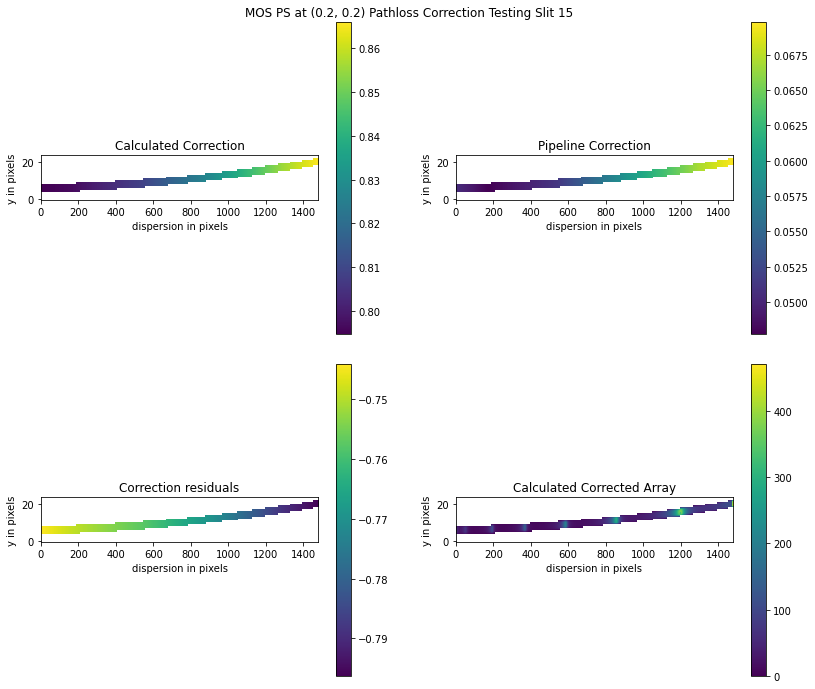

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  16
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


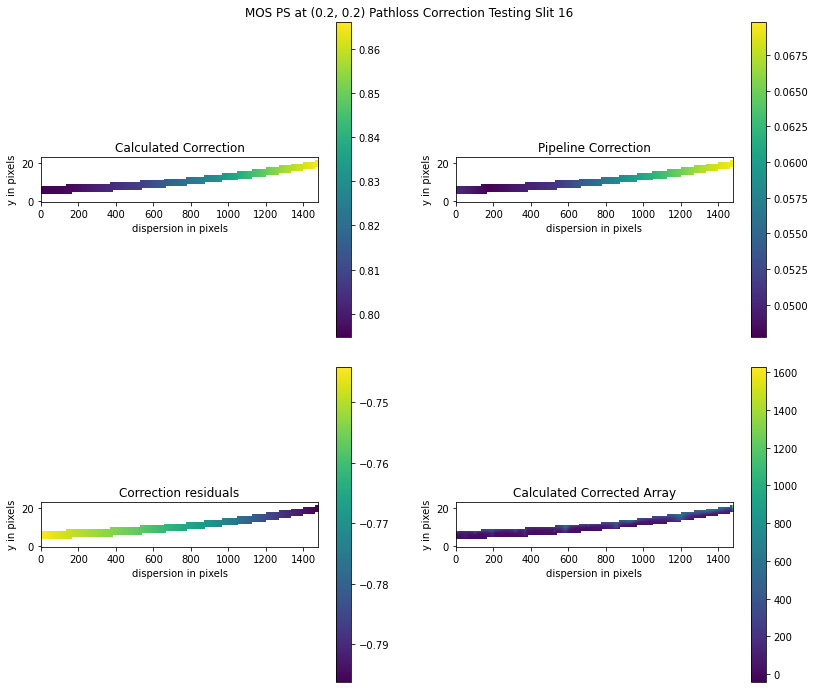

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  17
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


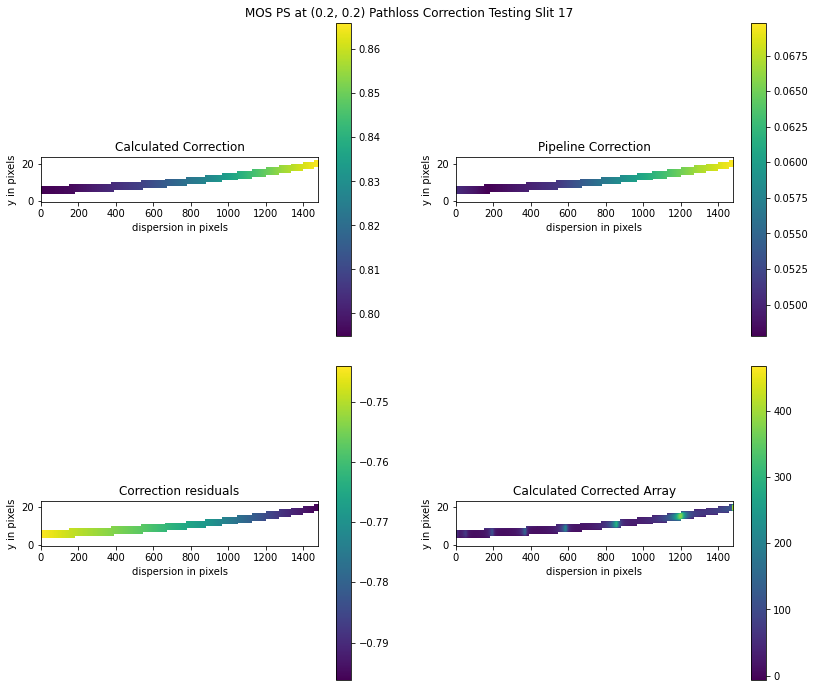

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  18
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


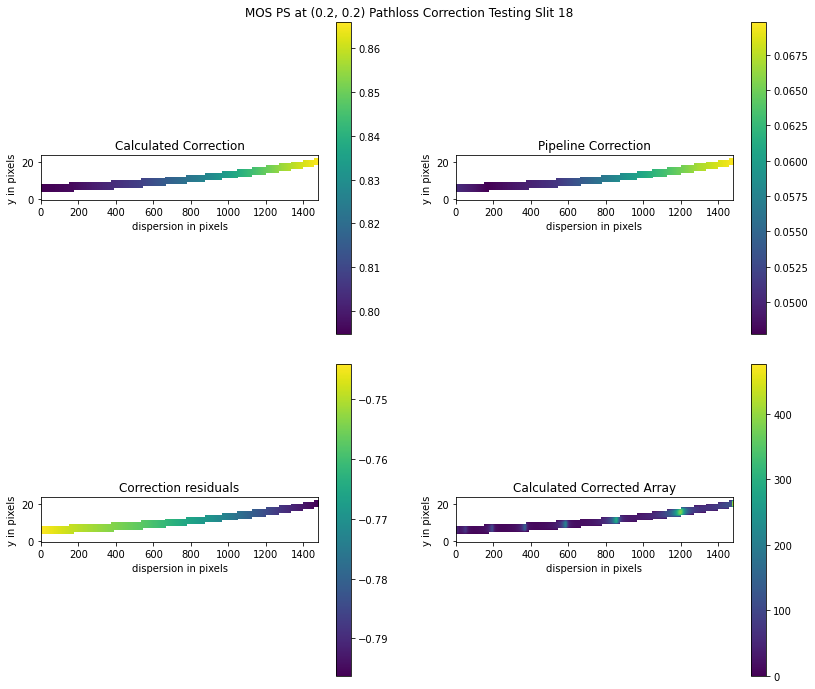

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  19
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


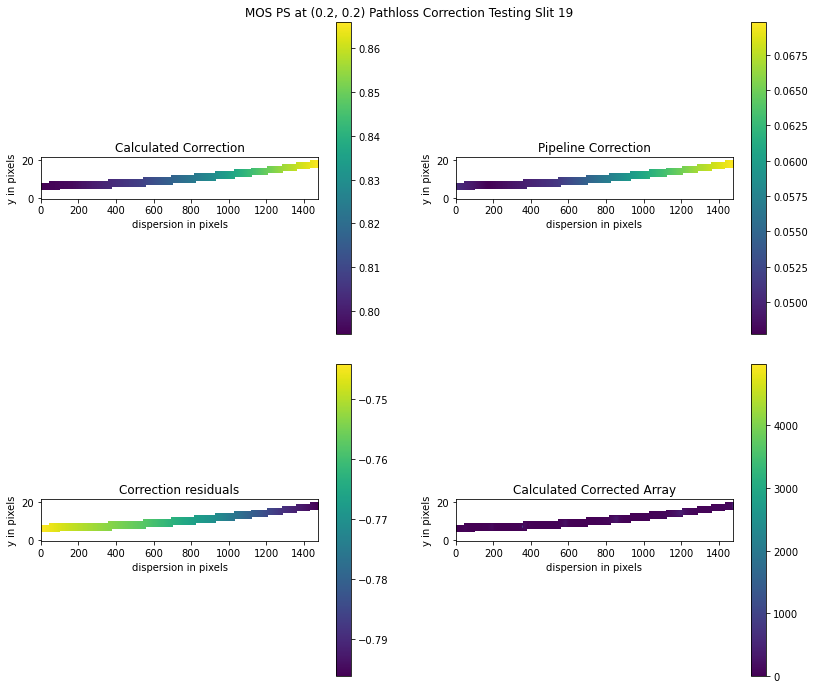

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  21
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


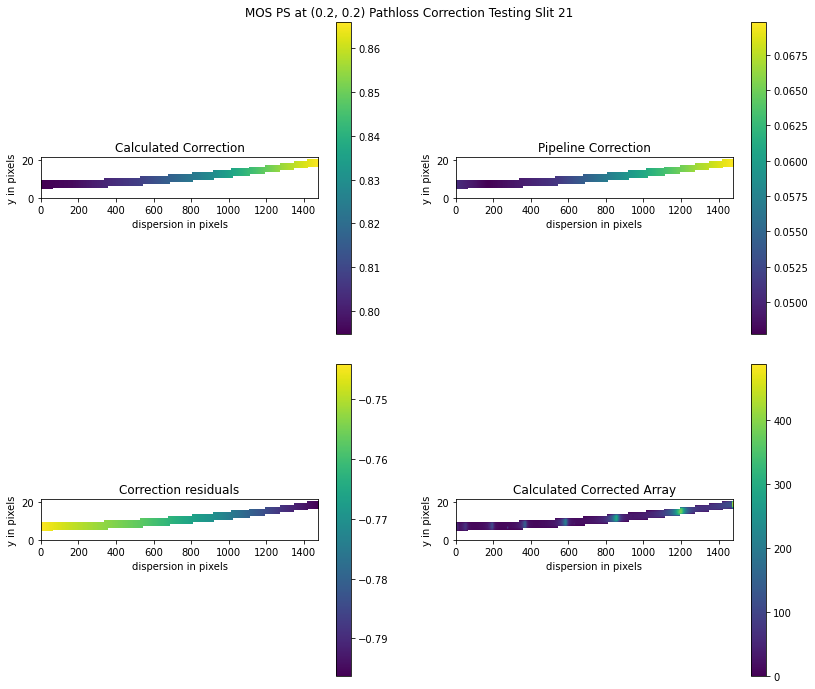

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  25
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


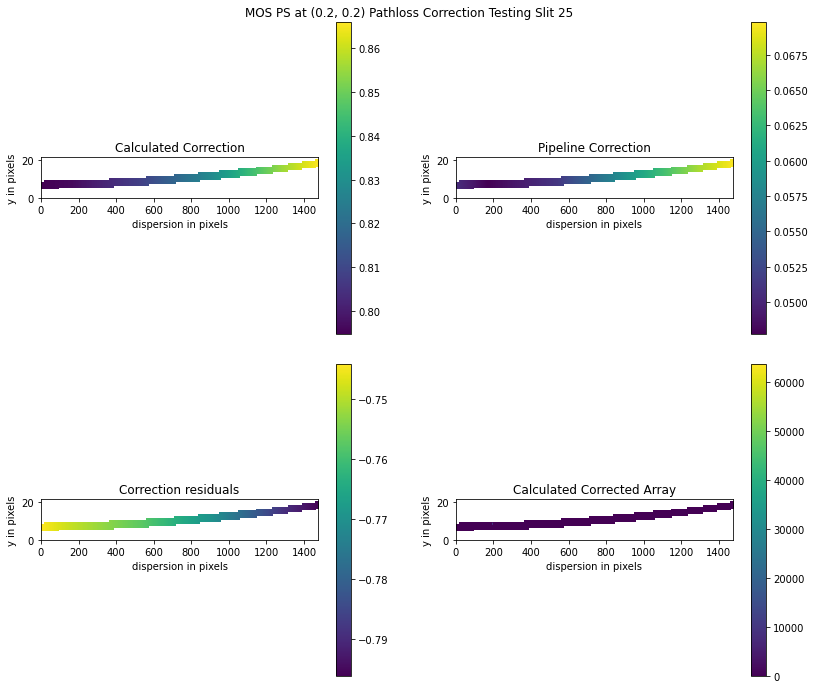

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  26
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


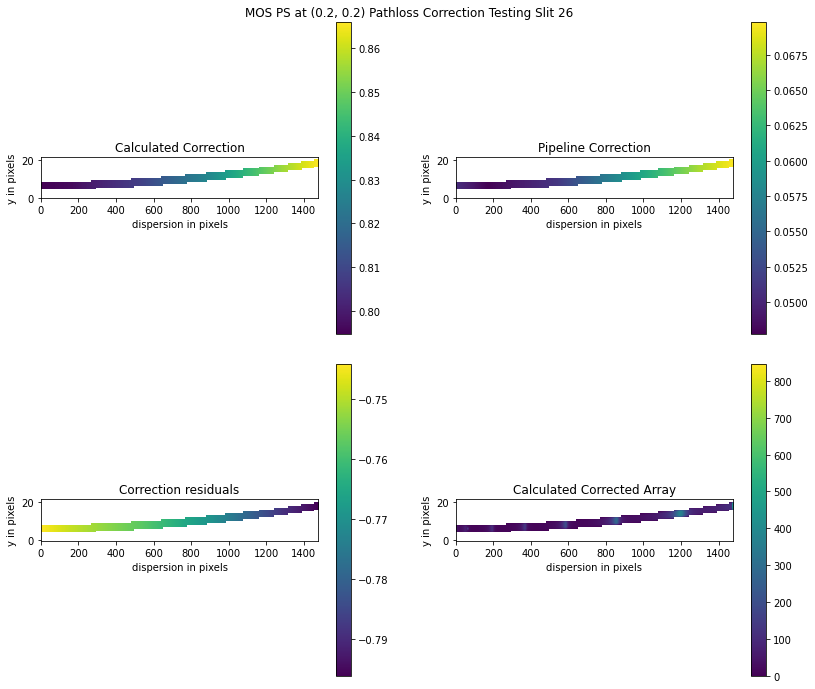

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  27
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


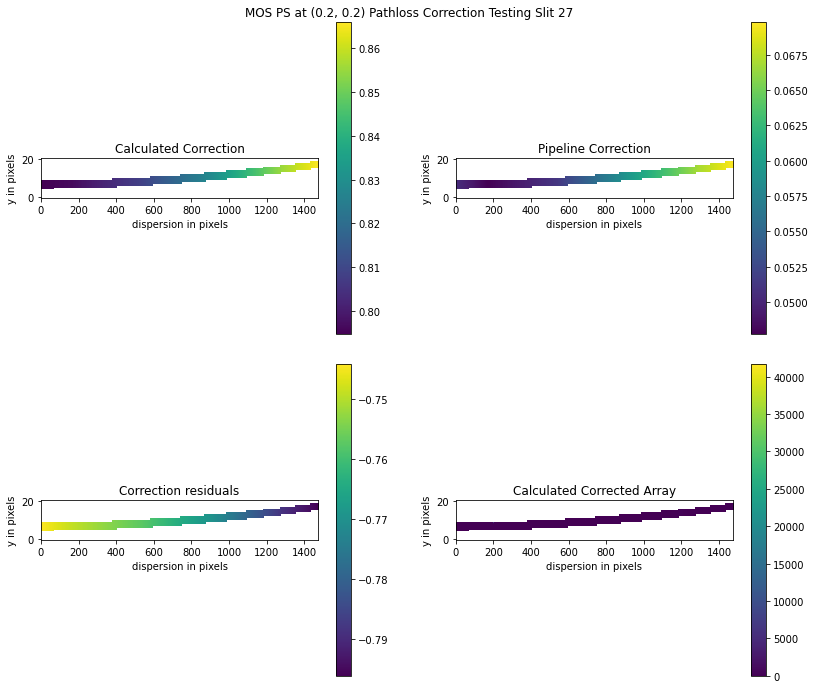

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  29
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


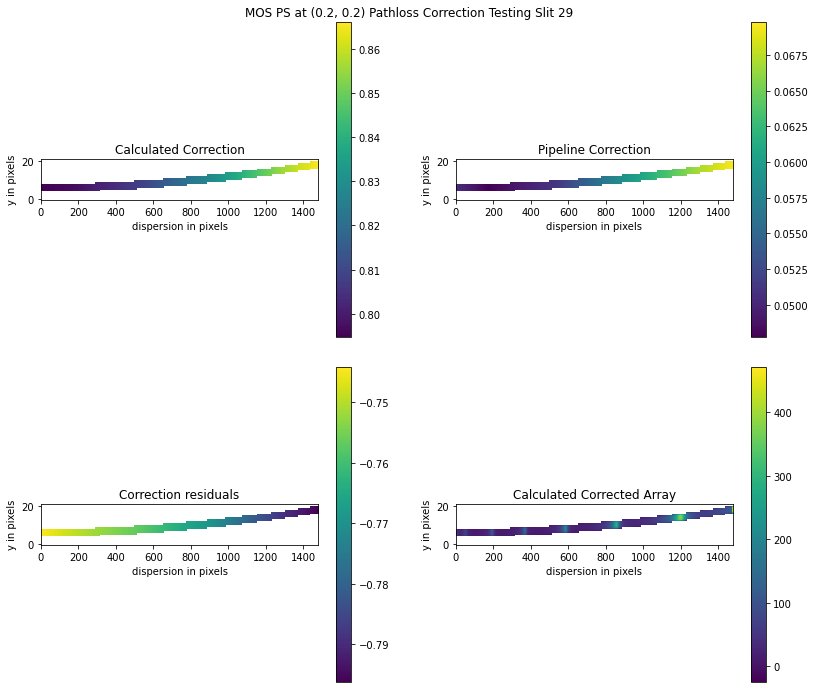

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  31
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


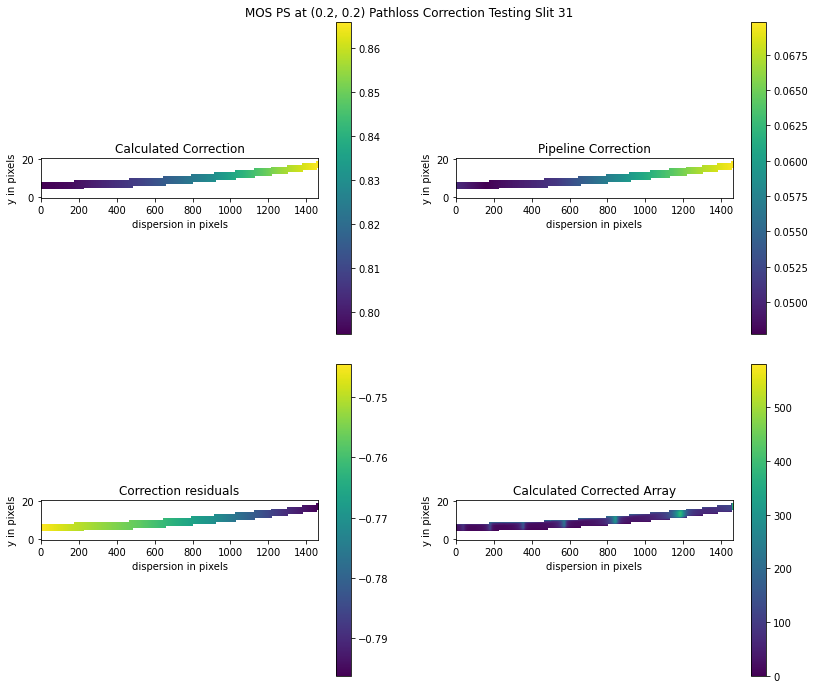

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  32
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


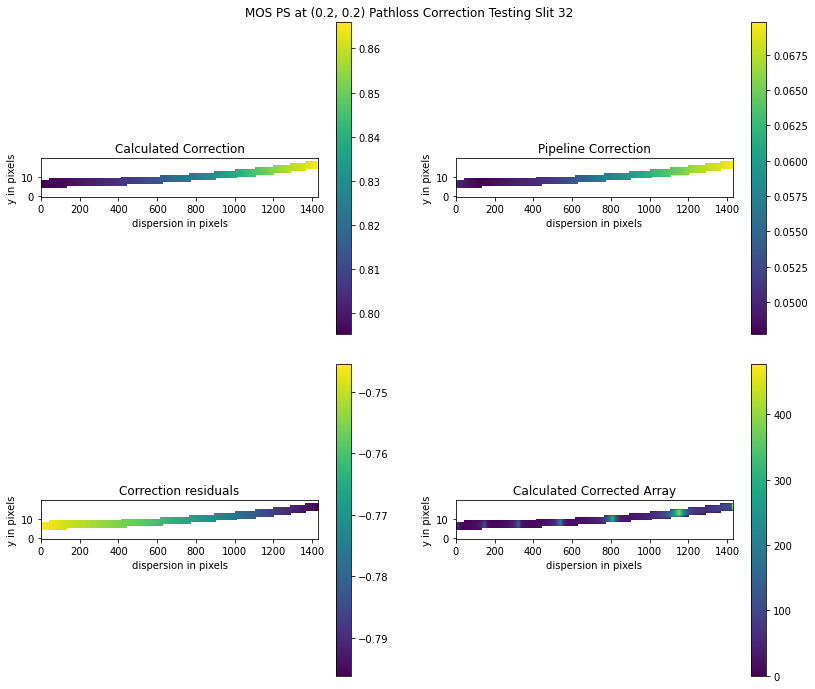

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  33
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


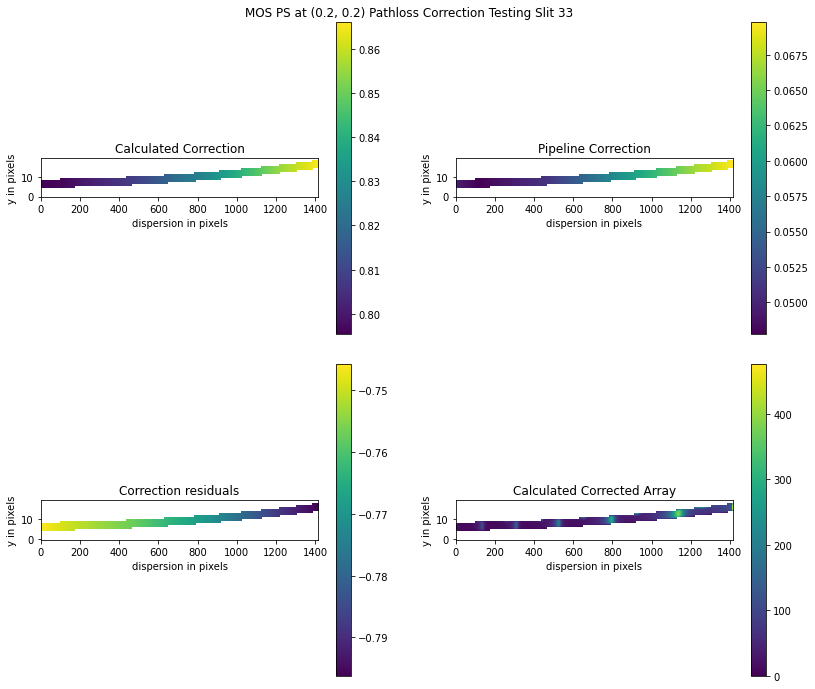

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  35
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


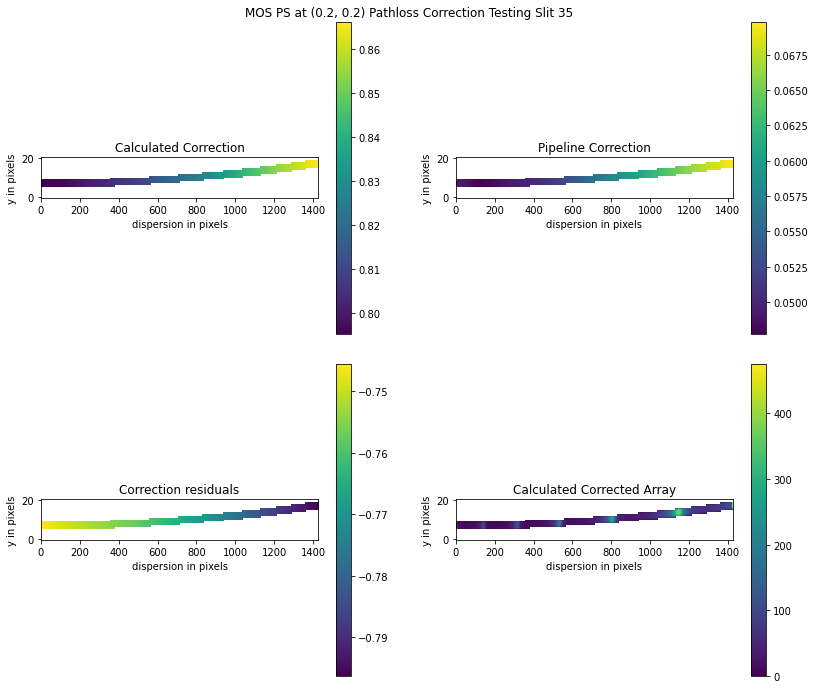

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  37
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


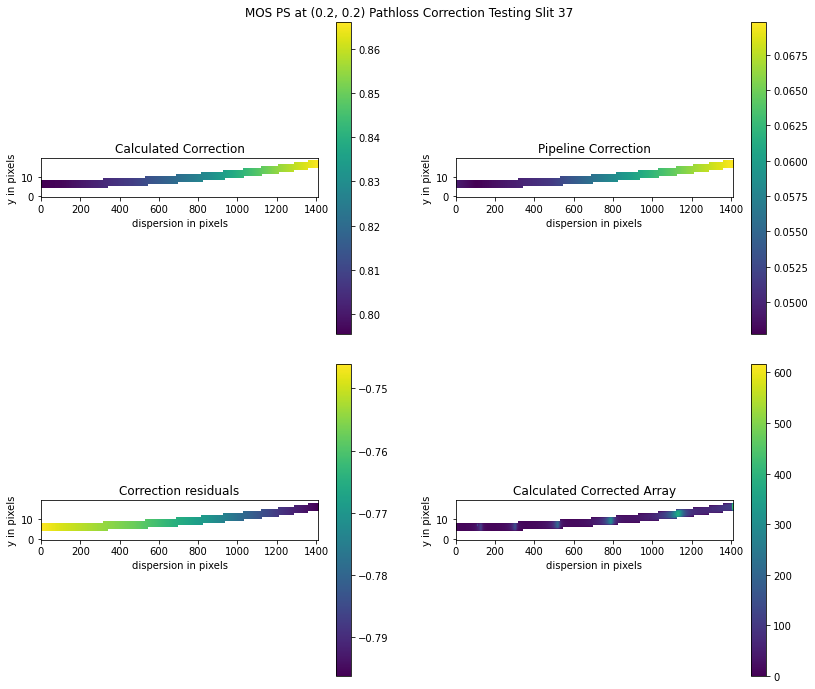

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  38
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


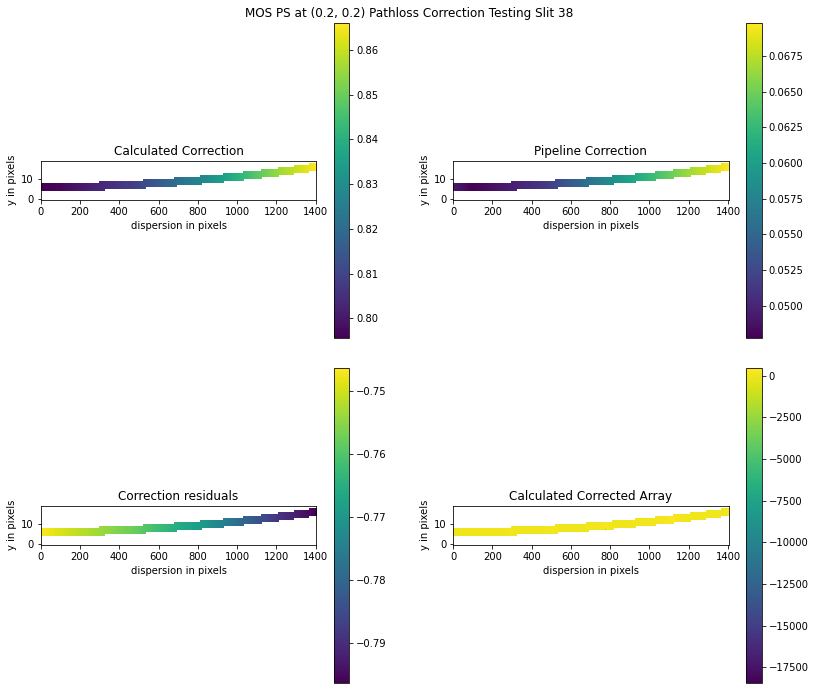

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  39
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


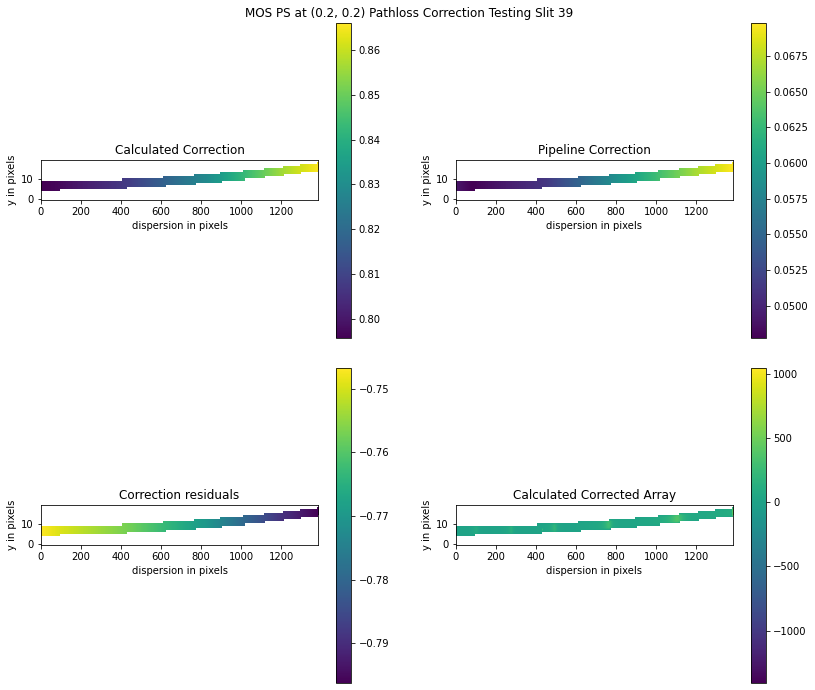

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  41
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


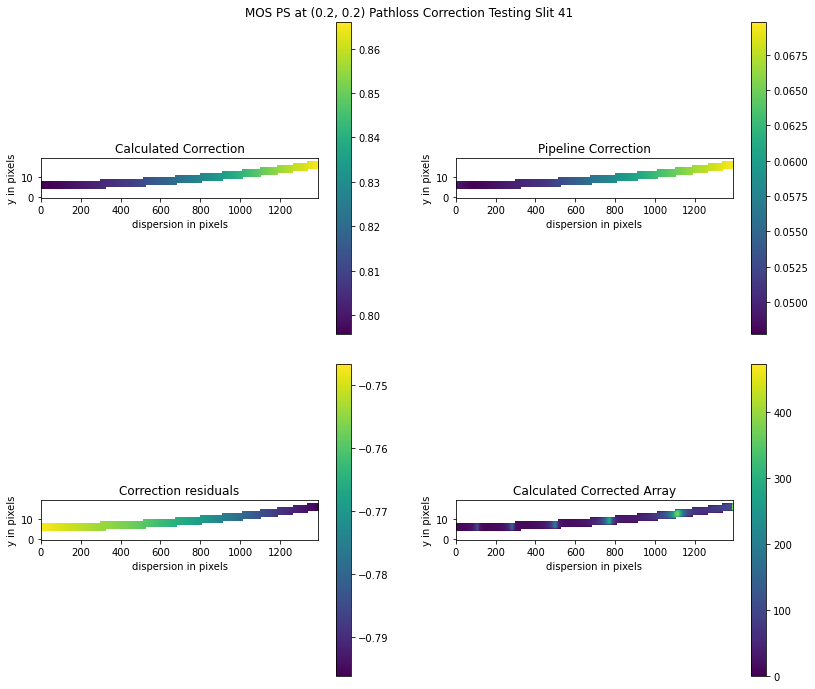

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  53
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


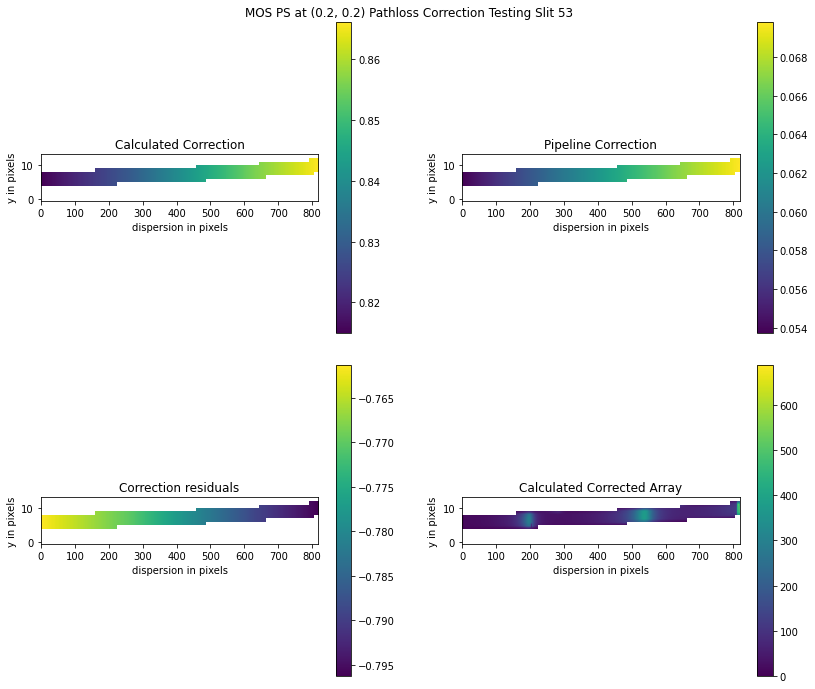

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  54
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


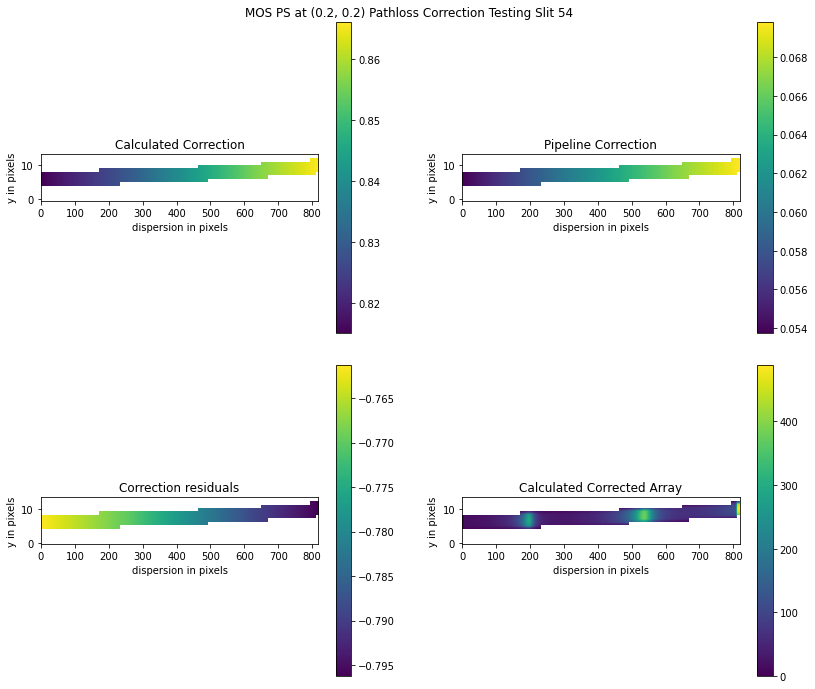

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  1
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


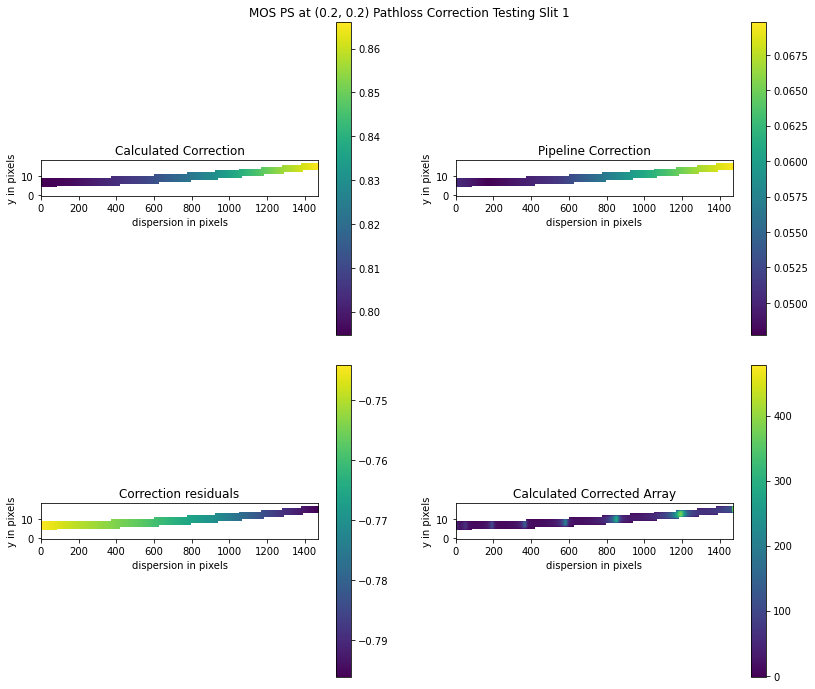

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  2
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


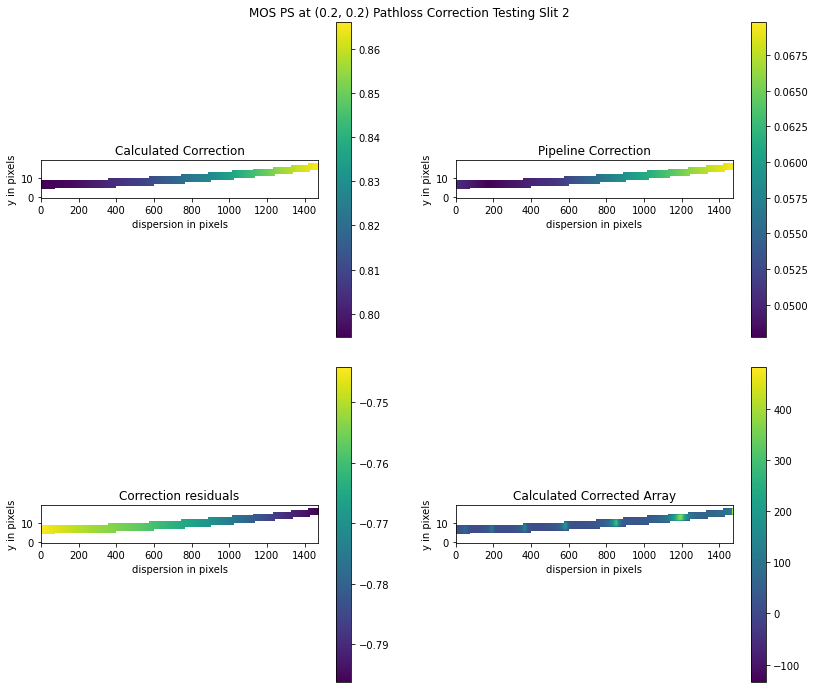

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  3
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


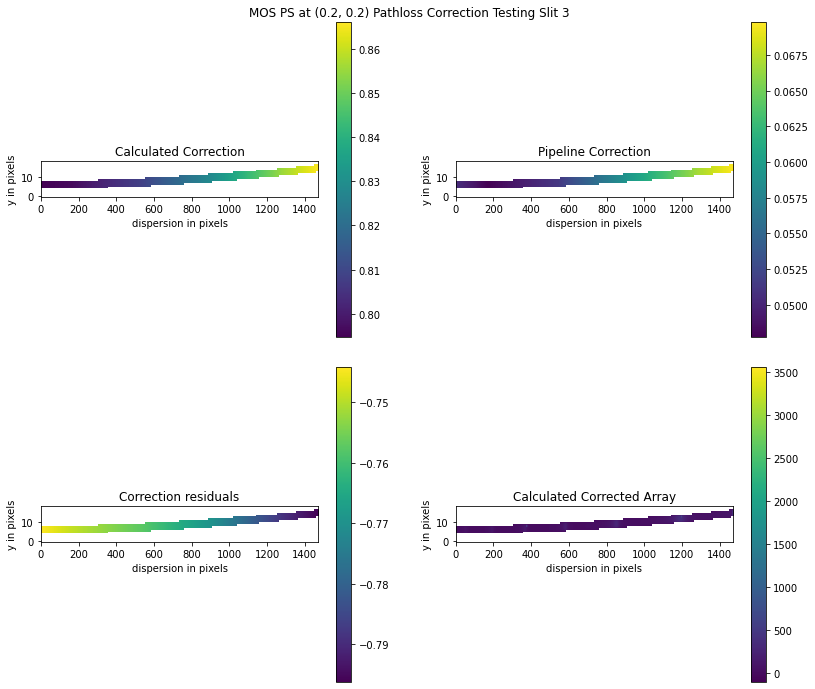

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  4
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


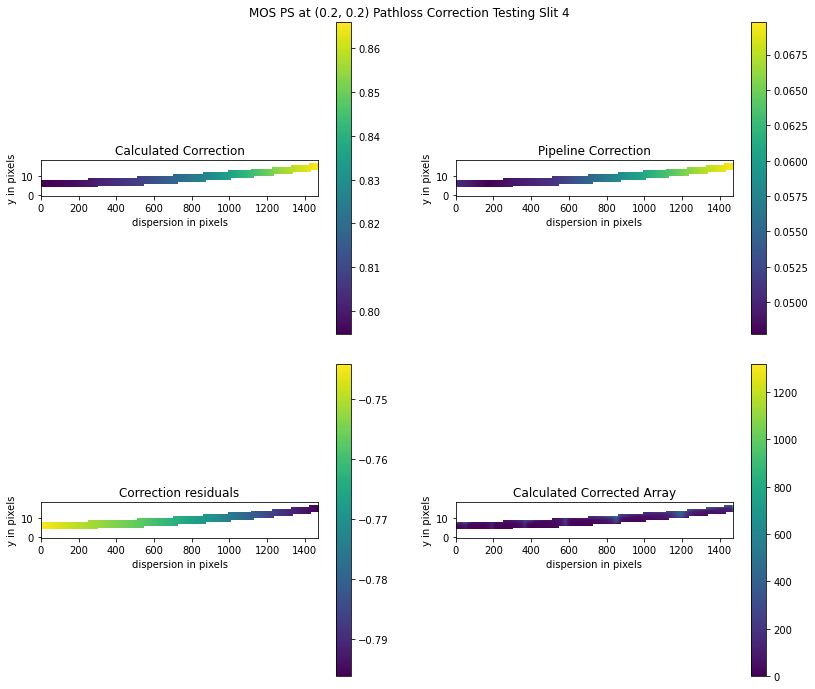

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  5
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


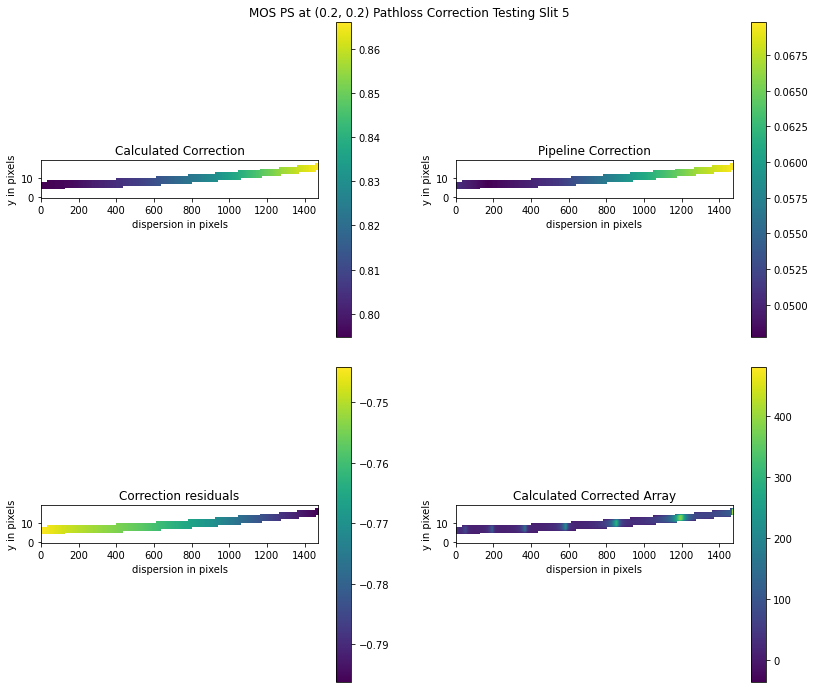

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  12
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


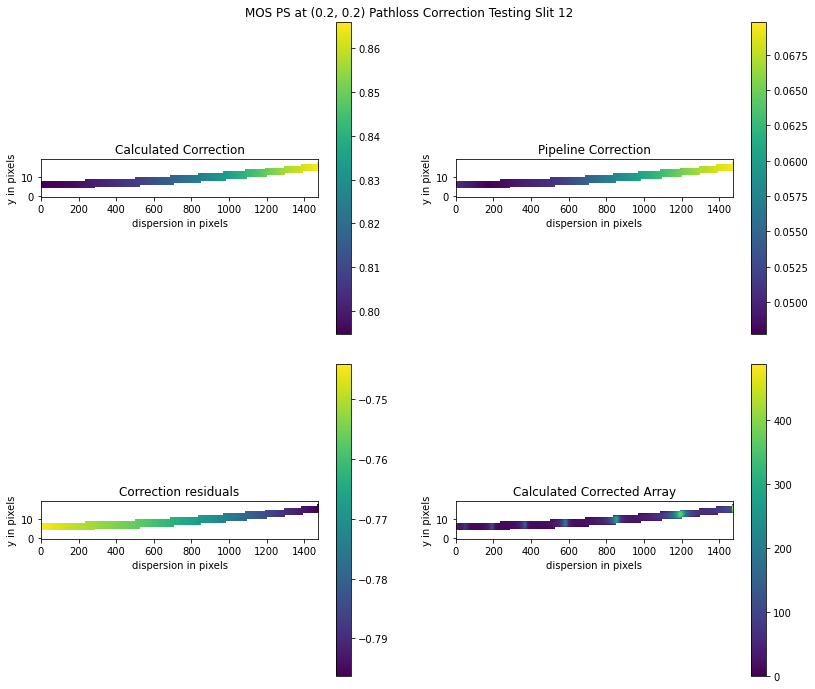

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  13
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


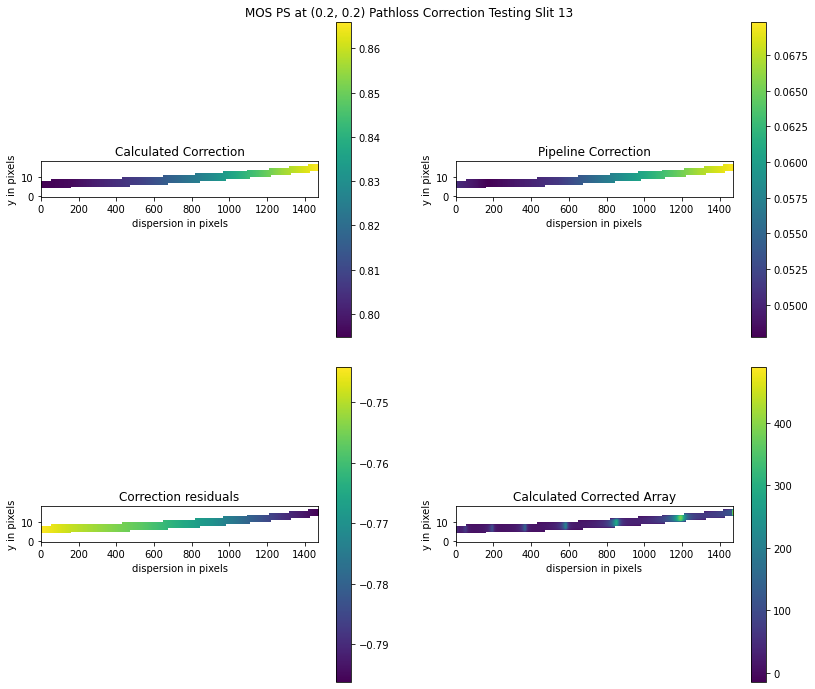

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  20
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


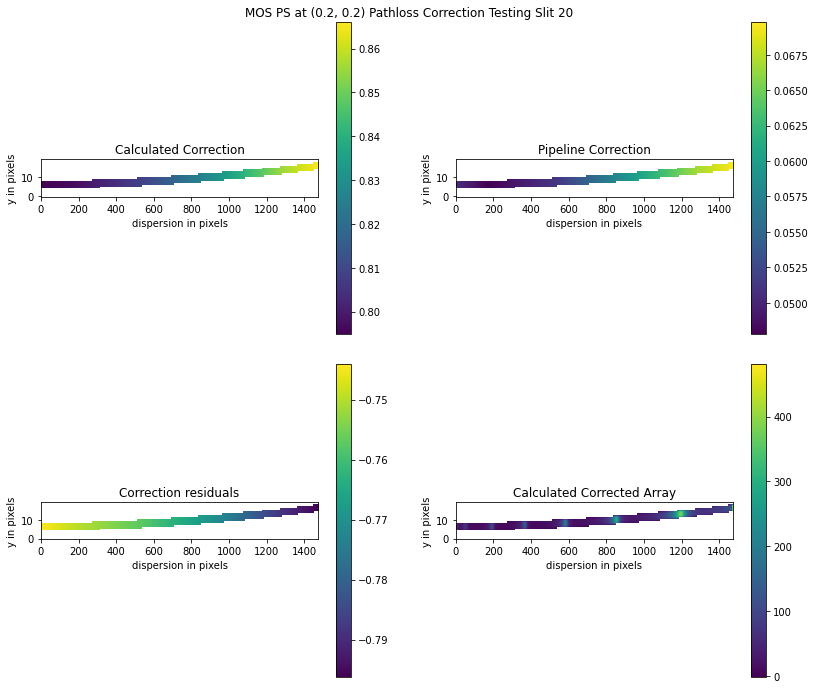

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  22
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


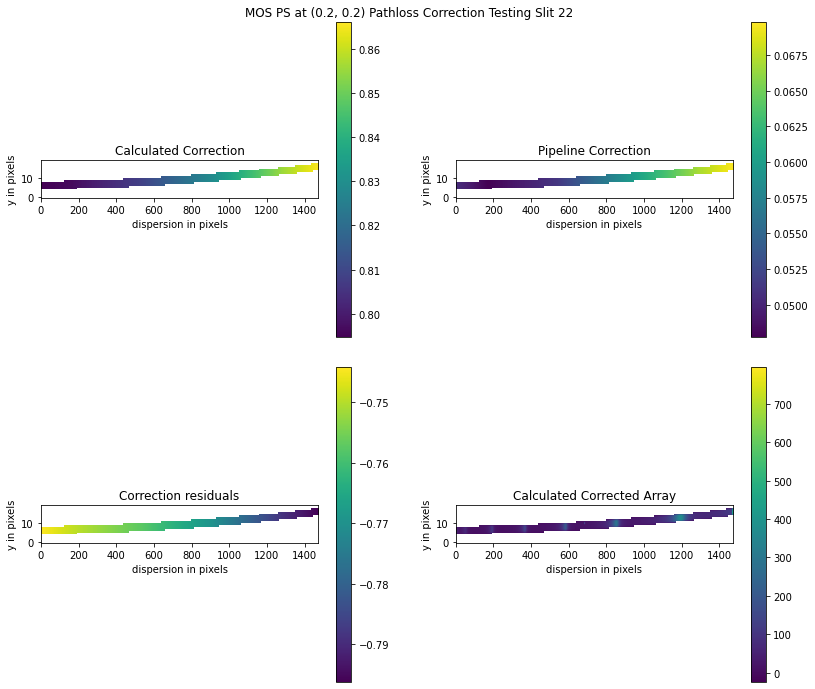

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  23
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


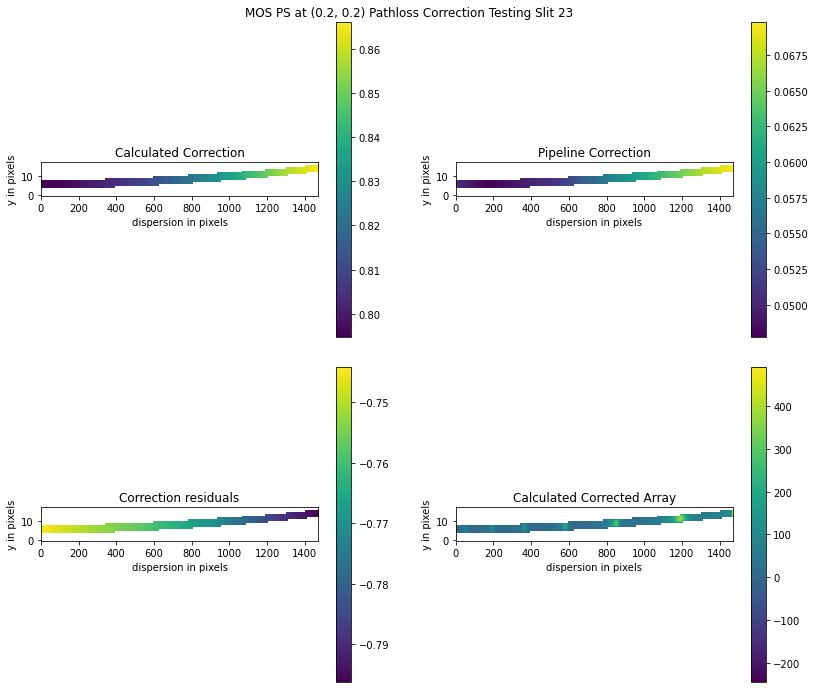

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  24
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


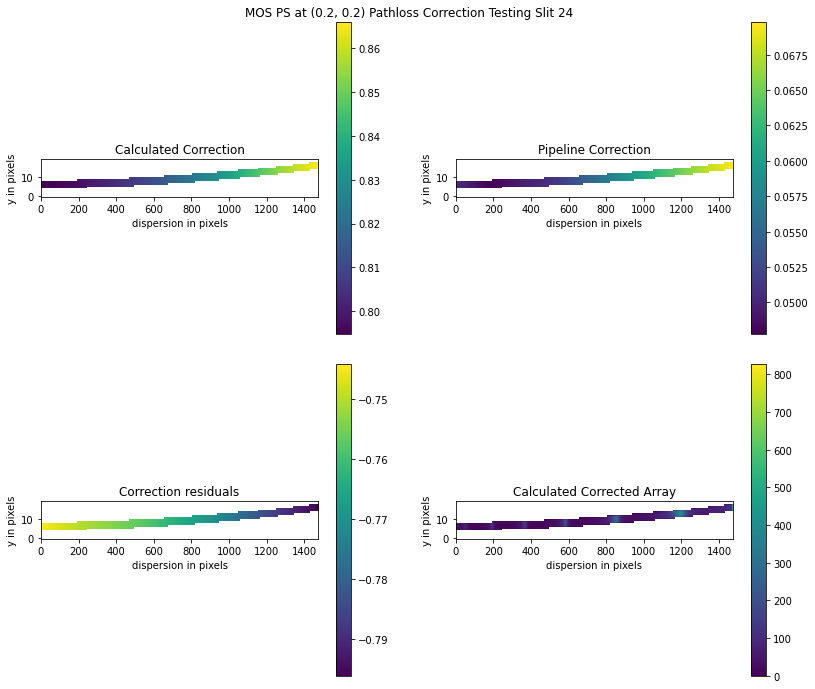

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  28
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


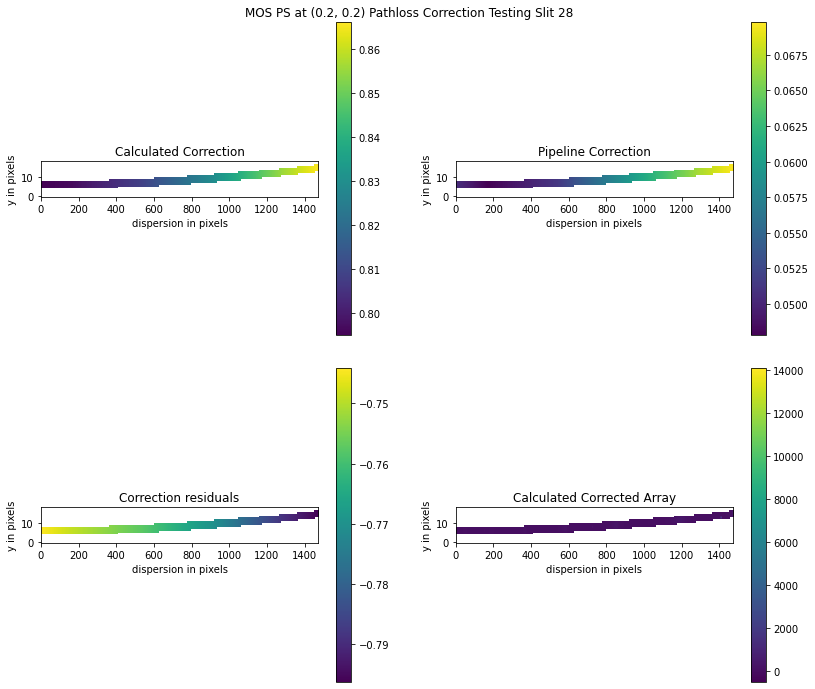

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  30
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


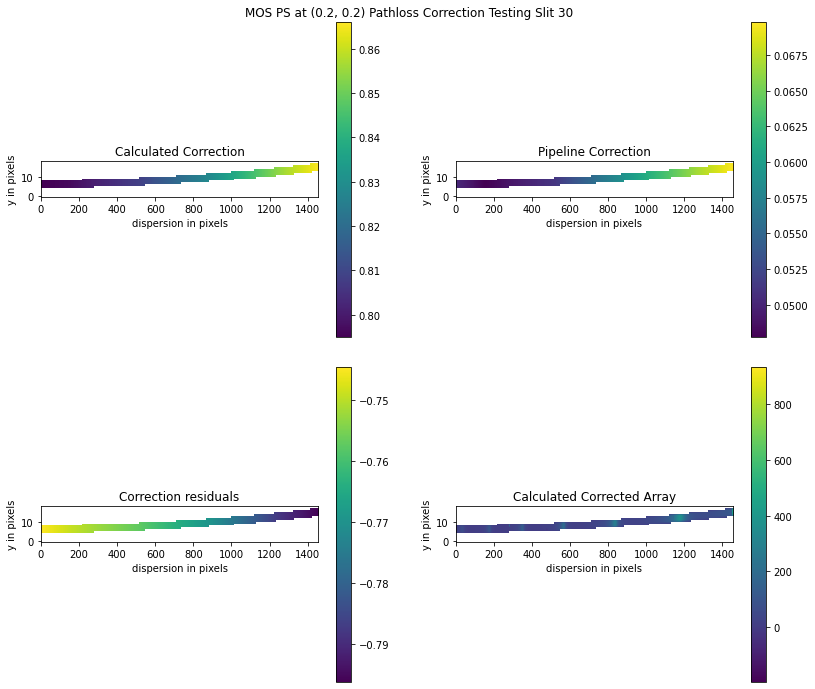

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  34
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


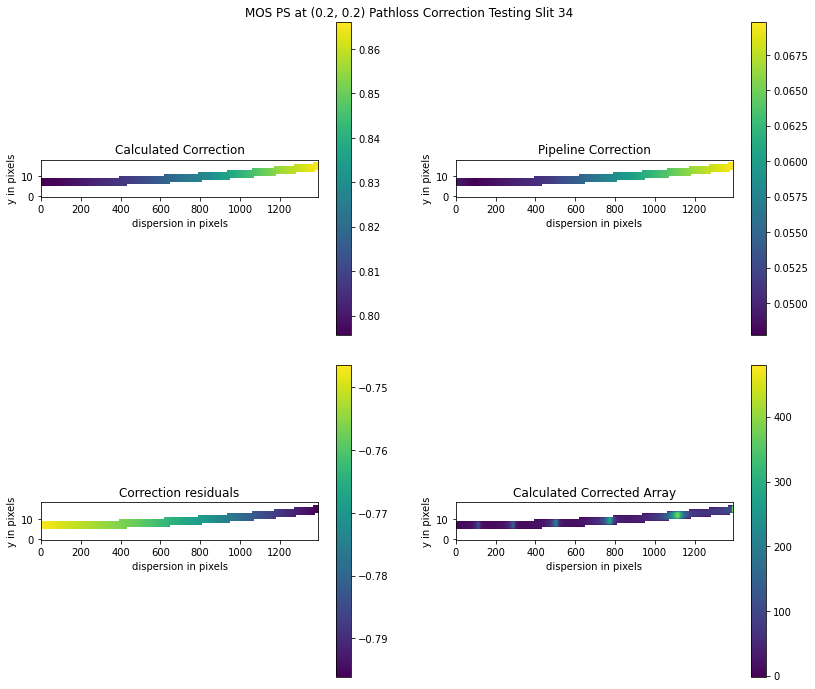

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  36
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


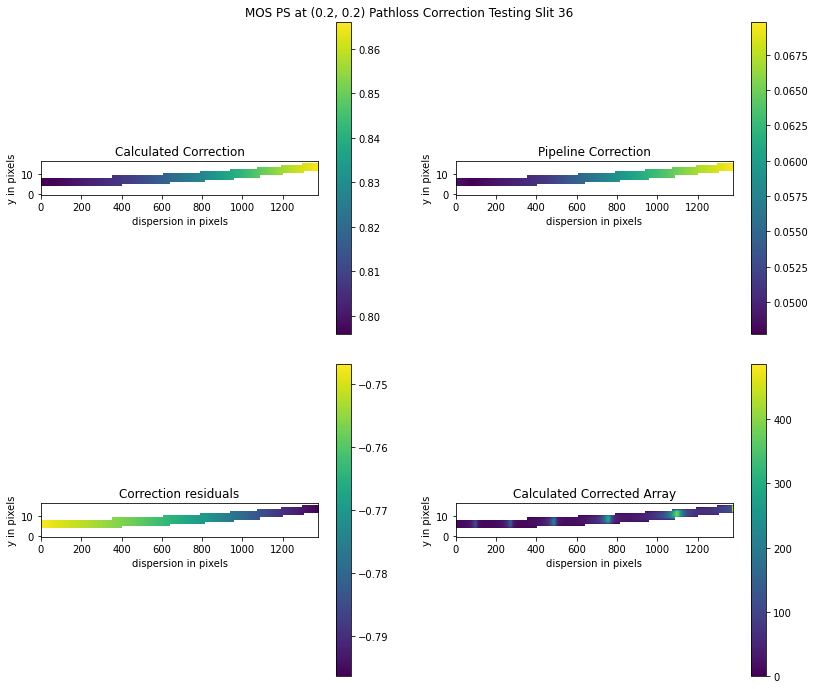

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  40
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


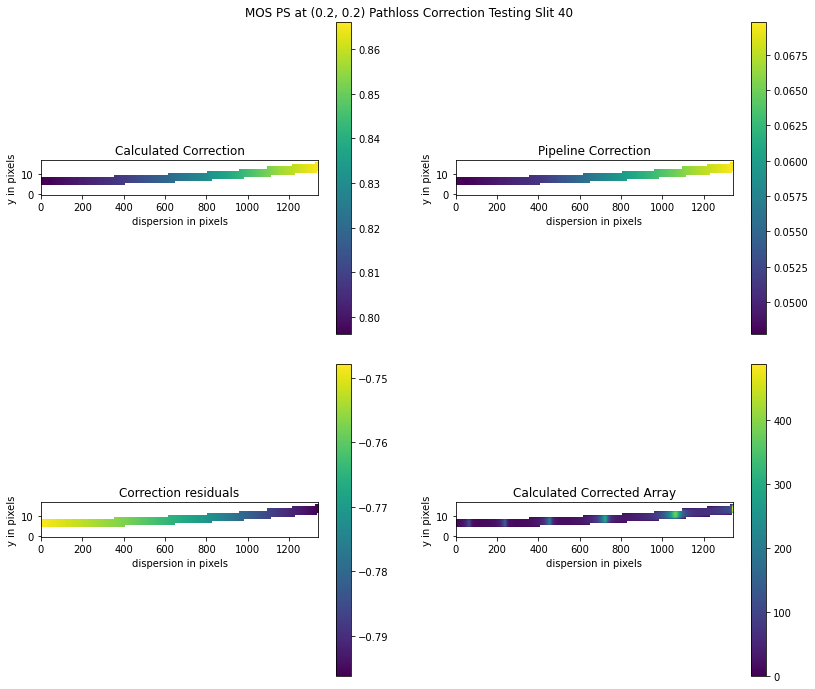

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  42
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


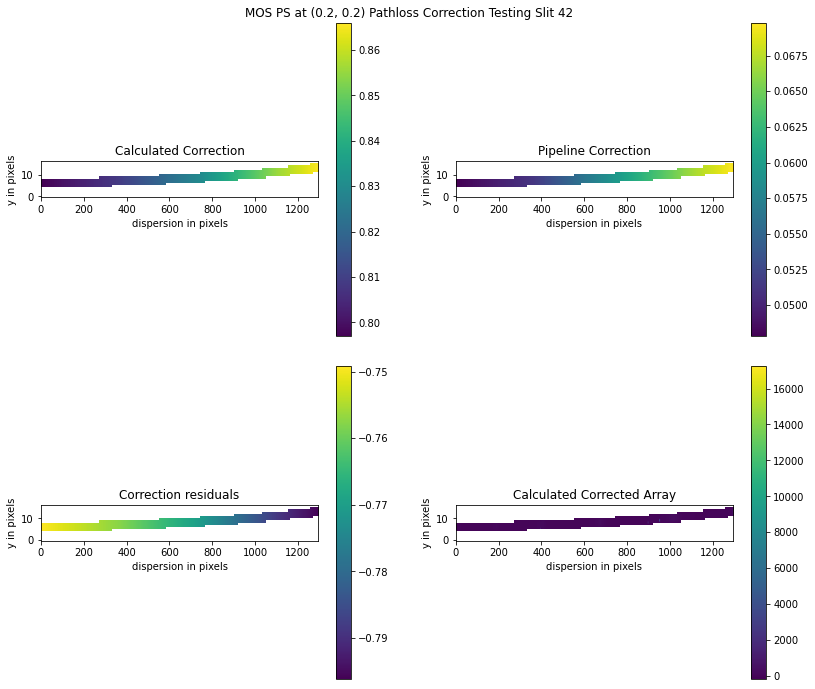

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  43
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


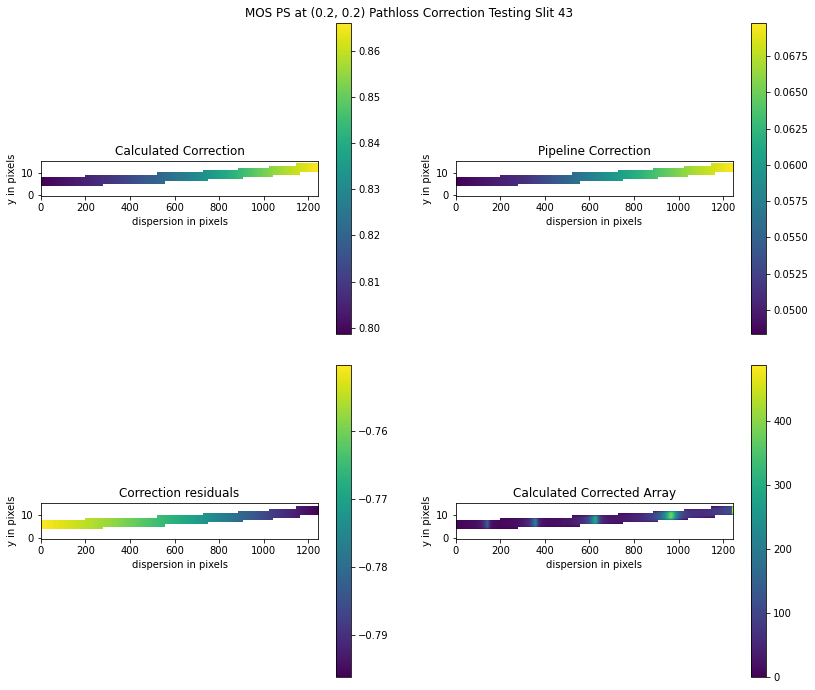

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  44
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


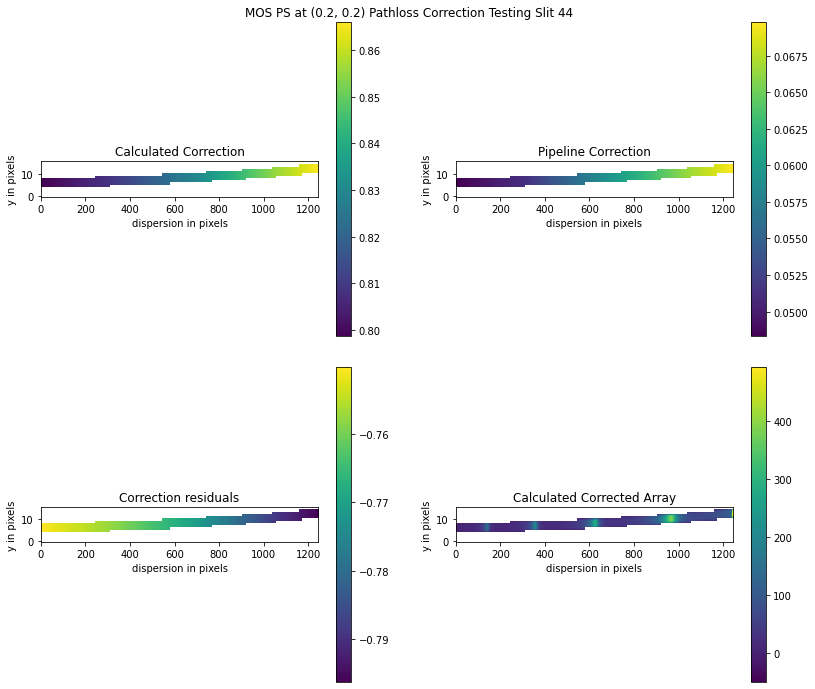

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  45
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


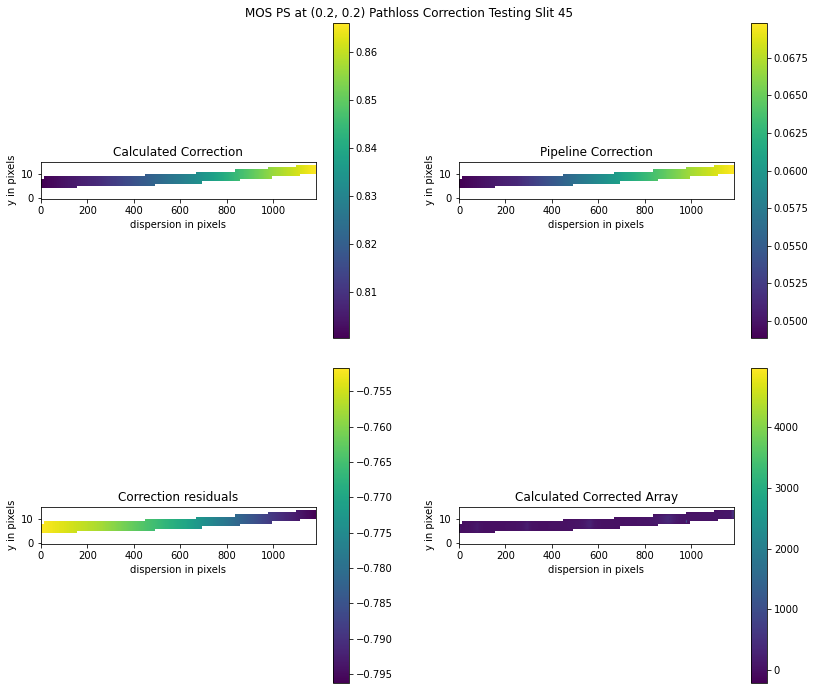

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  46
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


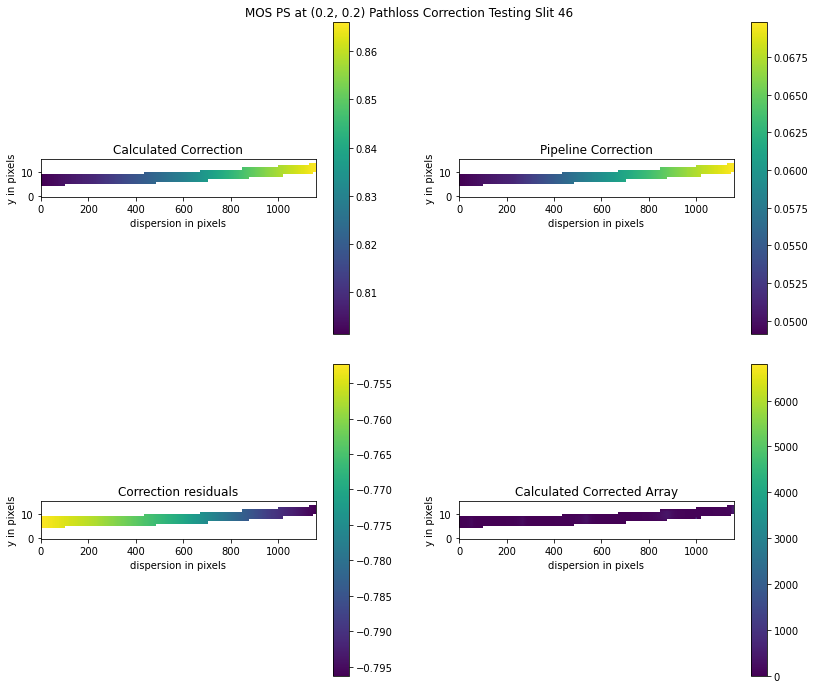

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  47
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


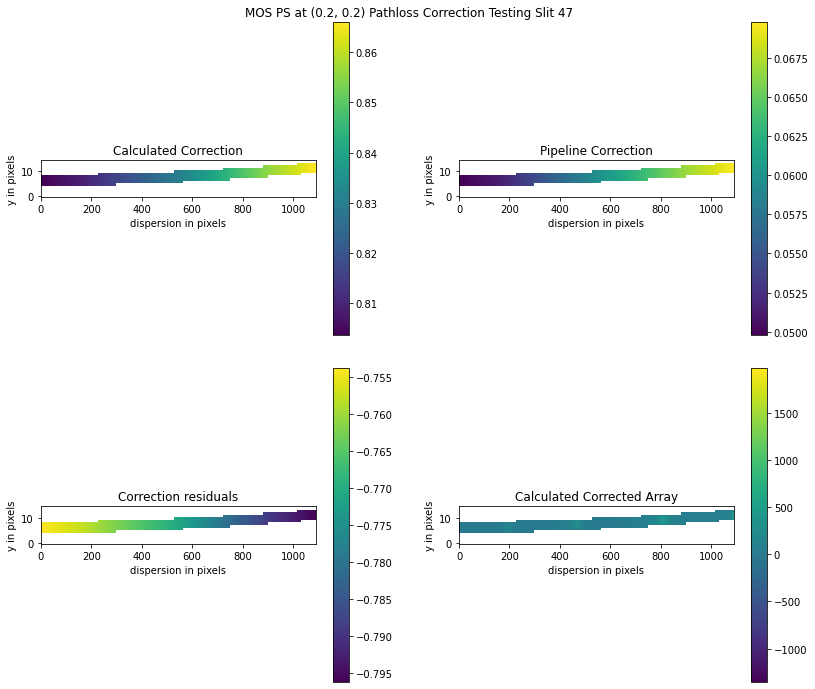

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  48
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


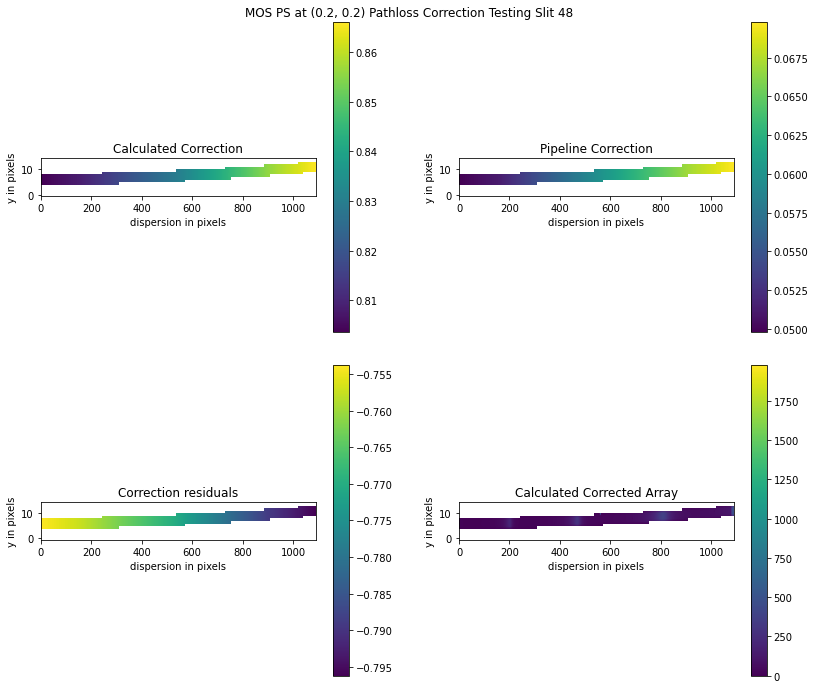

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  49
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


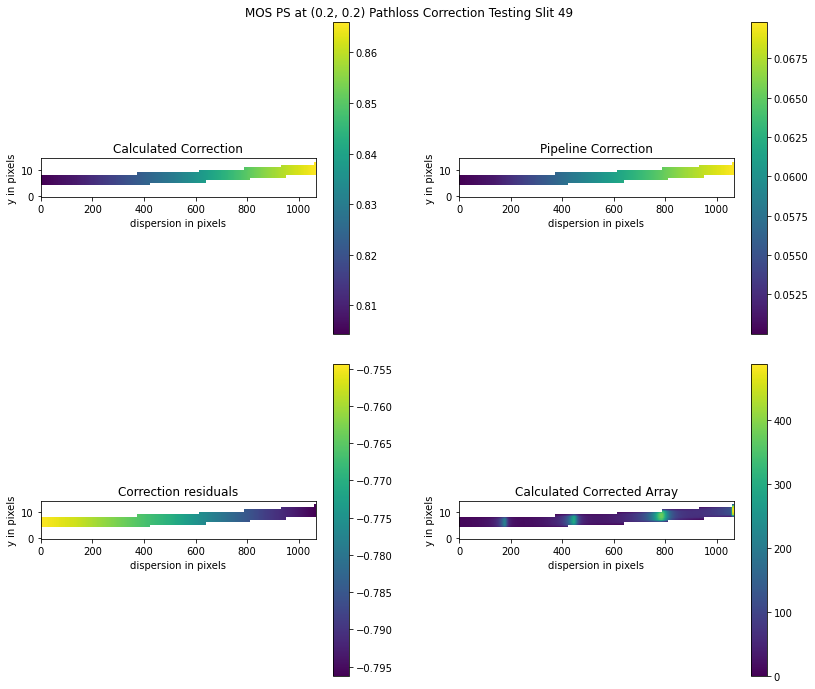

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  50
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


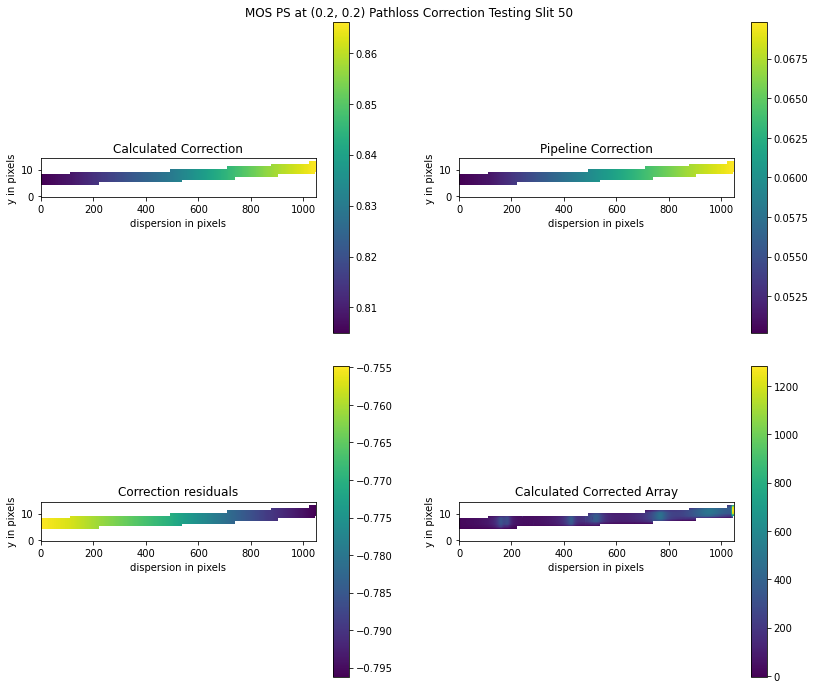

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  51
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


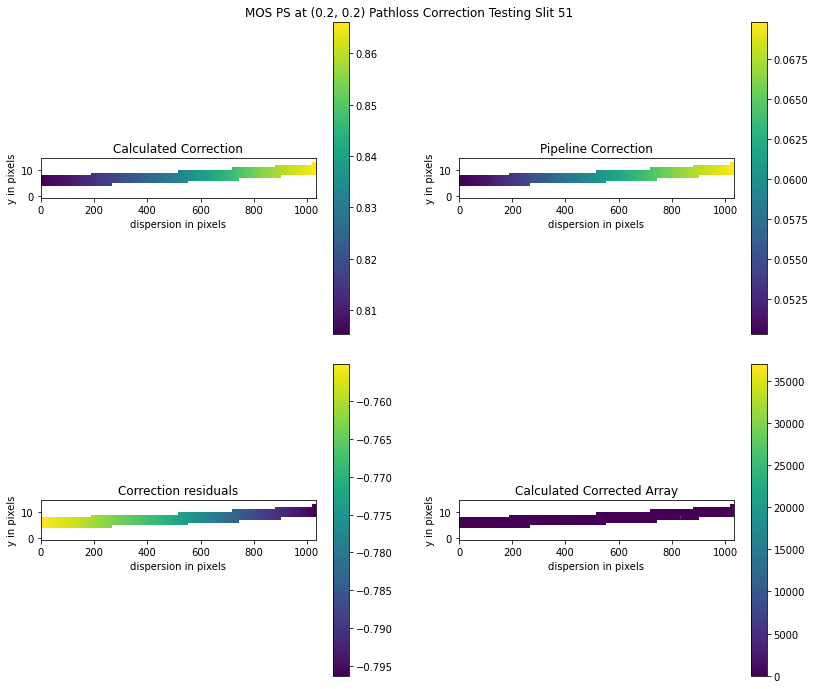

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  52
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


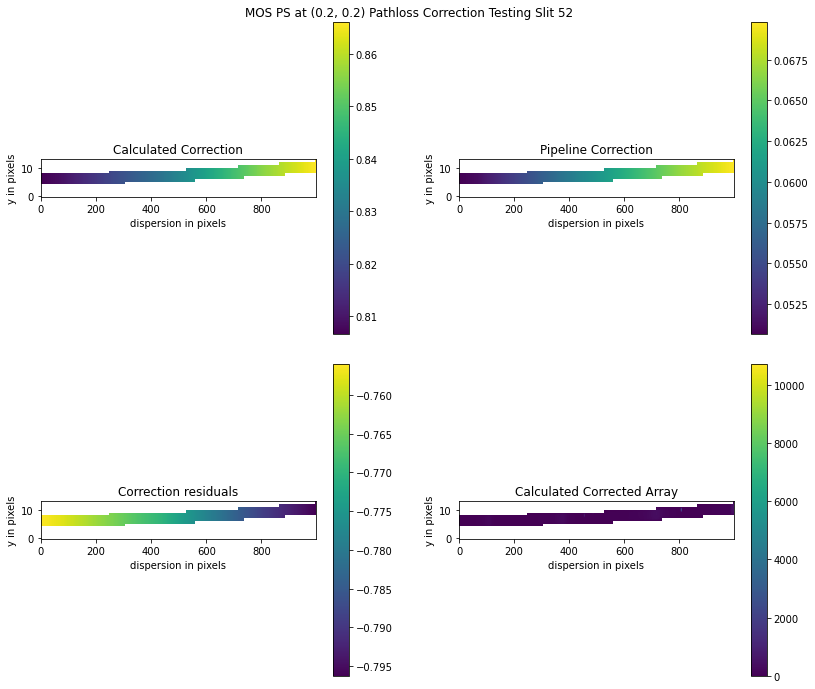

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  55
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


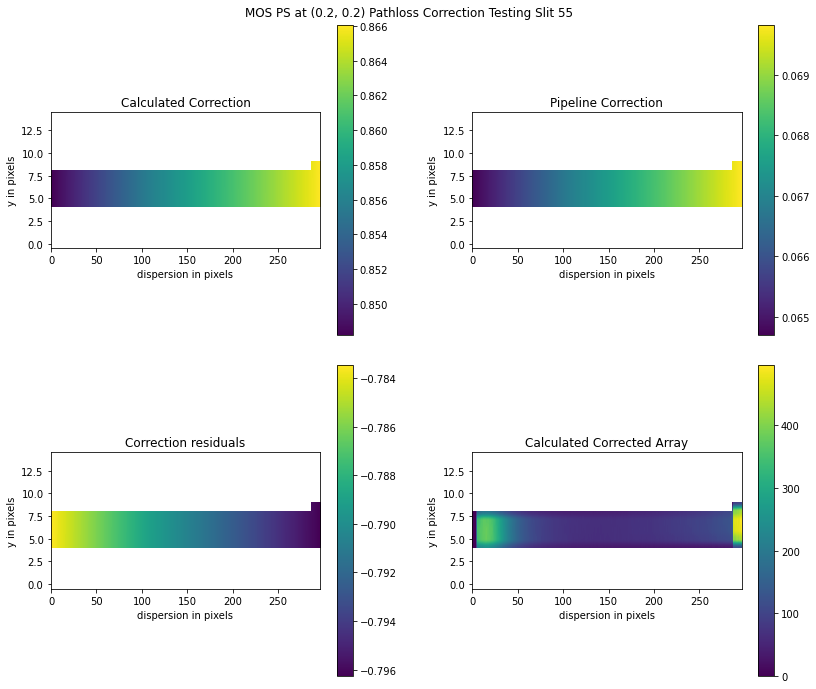

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  56
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


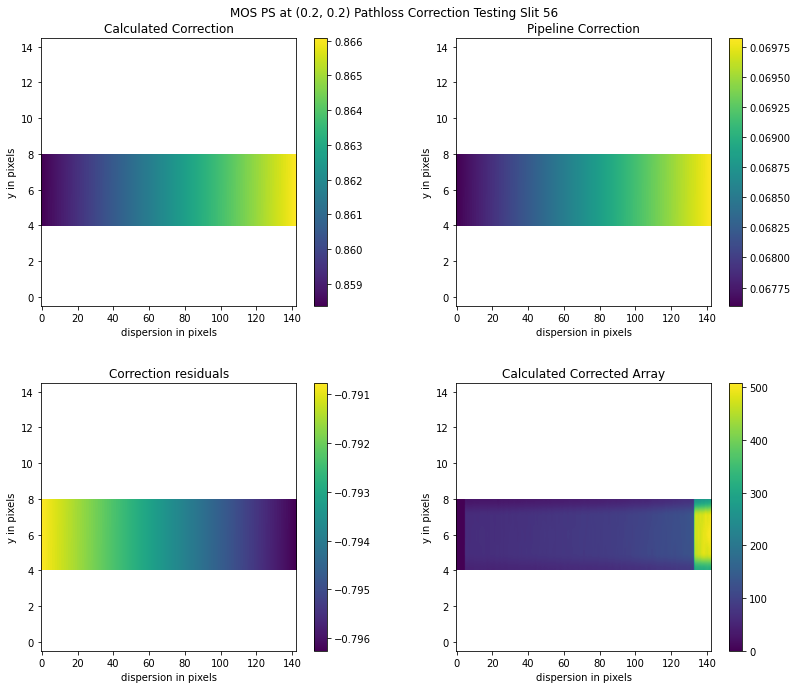

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  57
   Slitlet name in fits file previous to pathloss and in pathloss output file are the same.
   slit_x, slit_y (-0.5, -0.5)


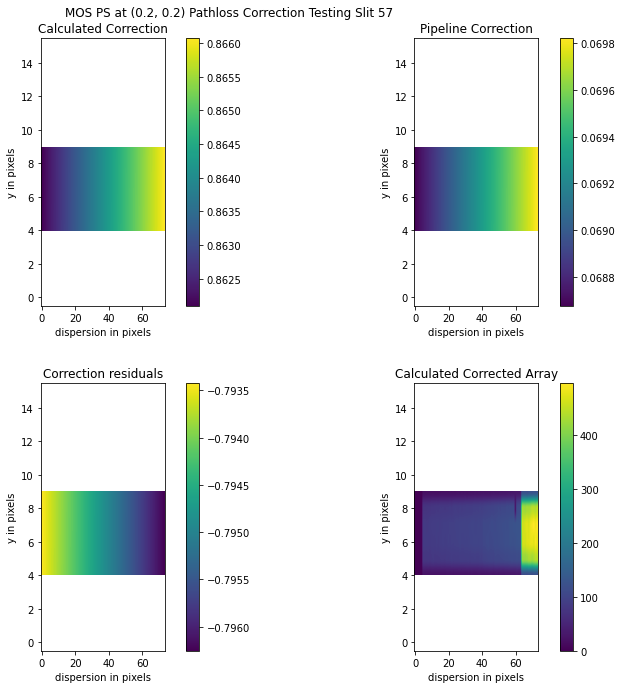

   Calculating statistics... 
   Unable to calculate statistics because
                          difference array has all outlier values.
                          Test will be set to FAILED.
 *** Result of the test: FAILED


 *** Final pathloss test result reported as FAILED *** 

('* Script MSA.py took ', '58.590855836868286 seconds to finish.')
Did pathloss validation test passed?  One or more slits FAILED path_loss test. 




In [7]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
threshold_diff = 9.999e-05

# other NPTT variables
writefile = False
show_figs = True
save_figs = False

# Get the data
detectors = ['nrs1', 'nrs2']
results_dict = {}
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        rate_object.meta.instrument.msa_metadata_file = msa_shutter_config
        if msa_shutter_config is not None:
            msa_metadata = rate_object.meta.instrument.msa_metadata_file
            print('MSA shutter configuration file: ', msa_metadata)
            if msa_metadata is None or msa_metadata == 'N/A':
                rate_object.meta.instrument.msa_metadata_file = msa_shutter_config

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
            skip_file = False
        except:
            print('An error occurred that made the pipeline crash, probably: No open slits fall on detector ', det)
            print("Skipping test for this file. \n")
            skip_file = True
            
        if not skip_file:                        
            if 'ifu' in uncal_basename.lower() or 'mos' in uncal_basename.lower():
                pipe_object = MSAFlagOpenStep.call(pipe_object)
            if 'ifu' not in uncal_basename.lower():
                pipe_object = Extract2dStep.call(pipe_object)
            pipe_object = SourceTypeStep.call(pipe_object)
            flat_field_object = FlatFieldStep.call(pipe_object)
            pathloss_object = PathLossStep.call(flat_field_object)

            # get the corresponding reference file from the pathloss datamodel
            reffile_path = pathloss_object.meta.ref_file.pathloss.name.replace("crds://", 
                                                        "https://jwst-crds.stsci.edu/unchecked_get/references/jwst/")

            # Run the validation test
            %matplotlib inline

            # determine the type of source from the datamodel
            source_type = pathloss_object.meta.target.source_type

            if 'fs' in uncal_file.lower():
                print('Running test for FS...')
                if source_type == 'POINT' or source_type is None:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile,
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)
                else:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_uni.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile, 
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)

            if 'mos' in uncal_file.lower():
                print('Running test for MOS...')
                if source_type == 'POINT' or source_type is None:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos_ps.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile,
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)
                else:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos_uni.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile, 
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)

            if 'ifu' in uncal_file.lower():
                print('Running test for IFU...')
                if source_type == 'POINT':
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_ps.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile,
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)
                else:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_uni.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile, 
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)


        else:
            result_msg = 'skipped'

        # Did the test passed 
        print("Did pathloss validation test passed? ", result_msg, "\n\n")
        rd = {mode_config: result_msg}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                print('Closing file: ', fd)
                open(fd.fd).close()
            except:
                print('File already closed: ', fd)


In [8]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    print(key, val)


These are the final results of the tests: 
mos_prism_clear skipped
mos_g140m_f100lp One or more slits FAILED path_loss test.


/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec
<br>**Updated On:** Mar/24/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 